# 1- Import thư viện và define helper function

## 1.1 Khai báo thư viện

In [5]:
!pip uninstall -y lightgbm && rm -rf LightGBM && git clone --recursive https://github.com/Microsoft/LightGBM && cd LightGBM && sh build-python.sh install --gpu
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!pip install catboost
!pip install optuna

Found existing installation: lightgbm 4.5.0
Uninstalling lightgbm-4.5.0:
  Successfully uninstalled lightgbm-4.5.0
Cloning into 'LightGBM'...
remote: Enumerating objects: 35261, done.
remote: Counting objects: 100% (5596/5596), done.
remote: Compressing objects: 100% (528/528), done.
remote: Total 35261 (delta 5370), reused 5069 (delta 5068), pack-reused 29665 (from 3)
Receiving objects: 100% (35261/35261), 23.21 MiB | 32.74 MiB/s, done.
Resolving deltas: 100% (26337/26337), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/kaggle/working/LightGBM/ex

In [6]:
# Common
import os
import numpy as np
from glob import glob
from tqdm import tqdm

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import cv2
import random
import skimage
from matplotlib import colors


# File & Data Processing
import pandas as pd
import zipfile
import re
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from catboost import CatBoostRegressor, Pool
from sklearn.feature_selection import mutual_info_regression
import shap as shap
import math
import missingno as msno
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

# Models
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model, ensemble, neighbors, svm, tree, gaussian_process, neural_network
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import torch
import optuna
import xgboost
import cupy as cp

# ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor

# Other
import time

## 1.2. Define các helper function

In [7]:
SEED = 91
random.seed(0)

In [8]:
## Ploting
def show_line_plot(data, name_xlabel, name_ylabel, name_title, name_label):
  plt.figure(figsize = (15,4))
  plt.xlabel(name_xlabel)
  plt.ylabel(name_ylabel)
  plt.title(name_title)
  plt.plot(data, label=name_label)
  plt.legend()
  plt.grid(True)
  plt.show()

def show_histogram_plot(data, name_xlabel, name_ylabel, name_title, vertical = False):
  plt.figure(figsize = (15,4))
  plt.xlabel(name_xlabel)
  plt.ylabel(name_ylabel)
  plt.title(name_title)
  sns.barplot(x = data.index, y = data.values)
  if (vertical == True):
    plt.xticks(rotation = "vertical")
  plt.show()

def show_circle_plot(data, name_title):
  fig = px.pie(names=data.index, values=data.values, width=700)
  fig.update_layout({"title":{'text': name_title,"x":0.5}})
  fig.show()

def show_multibar_plot(data, name_xlabel, name_ylabel, name_legend, name_title):
  ax = data.plot(kind = 'bar', title = name_title)
  ax.set(xlabel=name_xlabel, ylabel=name_ylabel)
  plt.legend(loc=(1.05, 0.5), title=name_legend)
  plt.show()

# 2- Nhập data và preprocessing

## 2.1. Nhập data

In [9]:
!gdown https://drive.google.com/uc?id=1OrE5CLfemZkYctrm2LPJ9SQJX1SFdL8-
!gdown https://drive.google.com/uc?id=1iUhIGqUqG0epjV5Dn2XyPR1QGEPW8E_R
!gdown https://drive.google.com/uc?id=1XP8ov3oJe6pqC4U-jvx_bunUaUjANSUF
!unzip public_test.zip
!unzip train.zip
!unzip private_test.zip

Downloading...
From: https://drive.google.com/uc?id=1OrE5CLfemZkYctrm2LPJ9SQJX1SFdL8-
To: /kaggle/working/public_test.zip
100%|██████████████████████████████████████| 82.4k/82.4k [00:00<00:00, 94.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iUhIGqUqG0epjV5Dn2XyPR1QGEPW8E_R
To: /kaggle/working/train.zip
100%|███████████████████████████████████████| 1.44M/1.44M [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XP8ov3oJe6pqC4U-jvx_bunUaUjANSUF
To: /kaggle/working/private_test.zip
100%|████████████████████████████████████████| 173k/173k [00:00<00:00, 86.4MB/s]
Archive:  public_test.zip
  inflating: X_public_test.csv       
Archive:  train.zip
  inflating: y_train.csv             
  inflating: X_train.csv             
Archive:  private_test.zip
  inflating: X_private_test.csv      


In [10]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_public_test = pd.read_csv('X_public_test.csv')
X_private_test = pd.read_csv('X_private_test.csv')

In [11]:
X_train

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,cat1,num7,num1,num2,num8,cat2,cat3,cat4,cat5,num3,num4,cat6,cat7,cat8,num9,num10,num5,num6,num11,num12
0,18,3002.615162,6.844050e+05,5.438812e+05,1984.083468,3,2,23,66,5.906644e+05,1.497083e+05,14005,5,490516,5976.987619,-22722.298810,1.087513e+06,1.293984e+06,3.164912e+05,NaN
1,23,1753.001446,9.696060e+05,3.536075e+06,1616.969212,3,2,35,58,9.573292e+05,1.422117e+03,13704,5,490281,5957.691379,-22690.811020,1.036992e+06,5.495982e+06,1.170566e+06,NaN
2,23,2534.010019,1.518483e+06,5.372982e+06,1984.083468,3,2,23,66,1.499355e+06,1.422117e+03,13907,5,490461,5931.756421,-22698.585783,1.929520e+06,6.097910e+06,1.454420e+06,NaN
3,28,2846.413447,1.238664e+06,1.468111e+06,1800.526340,3,2,23,50,7.128860e+05,8.911393e+05,13767,5,490721,5966.821025,-22715.495892,1.062252e+06,2.281633e+06,4.500649e+05,NaN
4,33,2846.413447,1.486196e+06,3.328124e+06,1616.969212,3,2,23,58,7.607118e+05,1.234051e+06,13858,5,490361,5987.458534,-22684.785579,2.072662e+06,6.286102e+06,1.311595e+06,-74.511949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17474,28,3002.615162,1.308619e+06,3.347995e+06,1984.083468,3,2,23,66,1.292110e+06,1.422117e+03,14026,5,490191,5942.035726,-22659.323230,2.047402e+06,5.089430e+06,1.199939e+06,NaN
17475,28,2690.211733,1.012655e+06,1.407507e+07,1984.083468,3,2,29,58,9.998411e+05,1.422117e+03,13627,9915,490211,5942.610556,-22673.512172,3.007290e+06,5.057825e+06,1.934031e+06,NaN
17476,23,1753.001446,5.929254e+05,2.773586e+06,1800.526340,3,2,17,50,5.853504e+05,1.422117e+03,13487,5,490541,5961.715186,-22718.022690,8.096501e+05,4.224609e+06,9.090104e+05,NaN
17477,33,3158.816876,1.986644e+06,5.709402e+06,1984.083468,3,2,35,74,1.961672e+06,1.422117e+03,13844,5,490776,5988.687092,-22712.969094,1.929520e+06,6.524574e+06,1.517678e+06,NaN


In [12]:
y_train

,wear_rate
0,531.0
1,265.0
2,336.0
3,350.0
4,480.0
...,...
17474,410.0
17475,306.0
17476,174.9
17477,655.0


In [13]:
X_public_test

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,cat1,num7,num1,num2,num8,cat2,cat3,cat4,cat5,num3,num4,cat6,cat7,cat8,num9,num10,num5,num6,num11,num12
0,23,1753.001446,6.359746e+05,2.796691e+06,1616.969212,3,2,23,50,4.365589e+05,3.350661e+05,13613,5,490891,5957.950616,-22704.611224,9.022709e+05,4.346718e+06,9.184199e+05,NaN
1,23,2690.211733,1.346287e+06,2.395509e+07,1616.969212,3,2,23,74,8.032237e+05,9.189430e+05,14096,5,490136,5955.121553,-22654.075265,1.912680e+06,3.911197e+07,7.938478e+06,NaN
2,18,1753.001446,4.745401e+05,2.933015e+06,1616.969212,3,2,23,58,4.684428e+05,1.422117e+03,13438,5,490531,5962.413999,-22725.797453,1.213814e+06,4.558614e+06,1.031248e+06,NaN
3,18,2690.211733,8.081714e+05,5.434191e+05,1984.083468,3,2,23,66,6.066063e+05,3.350661e+05,14103,5,490536,5977.607533,-22726.769298,1.306435e+06,1.092145e+06,2.913230e+05,94.494222
4,28,3315.018591,2.110410e+06,8.821746e+06,1616.969212,3,7,23,82,1.191144e+06,1.558427e+06,14040,5,490201,5967.136618,-22697.808307,3.200952e+06,9.876835e+06,2.302521e+06,65.193100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23,1753.001446,5.929254e+05,2.372470e+06,1616.969212,3,2,23,50,4.471868e+05,2.423872e+05,13641,5,490516,5981.236850,-22721.521334,1.079093e+06,3.687327e+06,8.155829e+05,-34.599896
996,23,2221.606590,1.023417e+06,2.927932e+06,1616.969212,3,12,23,66,7.713398e+05,4.184771e+05,13641,5,490526,5977.449737,-22709.859189,1.289595e+06,4.550712e+06,9.809774e+05,NaN
997,28,2690.211733,1.895164e+06,3.130801e+06,2167.640596,3,2,23,74,1.409018e+06,8.077284e+05,14047,5,490681,5962.143491,-22732.211633,2.468405e+06,4.639780e+06,1.080032e+06,NaN
998,28,2690.211733,1.653012e+06,3.328124e+06,1984.083468,3,2,23,66,1.632205e+06,1.422117e+03,14040,5,490296,5957.432142,-22683.036257,2.182123e+06,5.172752e+06,1.209896e+06,NaN


In [14]:
X_private_test

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,cat1,num7,num1,num2,num8,cat2,cat3,cat4,cat5,num3,num4,cat6,cat7,cat8,num9,num10,num5,num6,num11,num12
0,18,2690.211733,8.458395e+05,5.868579e+05,2351.197725,3,2,23,58,8.351076e+05,1422.116564,14054,5,490531,5962.402727,-22727.158037,1.323275e+06,9.348392e+05,2.887917e+05,88.907338
1,23,2065.404875,6.090688e+05,3.328124e+06,1616.969212,3,2,23,58,6.012923e+05,1422.116564,13683,5,490891,5959.032648,-22705.388700,9.527914e+05,5.172752e+06,1.115149e+06,29.966569
2,33,3471.220305,2.271845e+06,4.270838e+06,1984.083468,3,12,35,90,1.818194e+06,742853.143055,13942,5,490201,5968.658226,-22700.723843,2.847309e+06,6.638064e+06,1.507085e+06,54.686102
3,23,2690.211733,9.211756e+05,7.698554e+05,1984.083468,3,2,35,66,6.916300e+05,381405.517641,14026,5,490996,5974.981351,-22730.656680,1.239074e+06,3.879829e+06,7.499133e+05,NaN
4,28,2534.010019,1.782160e+06,5.898109e+07,1984.083468,3,2,35,74,1.759741e+06,1422.116564,13473,9785,490361,5984.719641,-22682.258781,3.226212e+06,3.157638e+07,8.849059e+06,52.187400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,23,2221.606590,8.727452e+05,2.542528e+06,1616.969212,3,2,23,58,5.906644e+05,474084.395952,13655,5,490561,5974.271268,-22716.078999,1.769539e+06,4.669949e+06,1.044536e+06,57.954467
2050,43,2065.404875,1.437766e+06,5.199689e+06,1800.526340,3,2,29,66,1.233656e+06,325798.190654,13641,5,490666,5982.476678,-22720.743857,1.710598e+06,6.465674e+06,1.462100e+06,-84.484032
2051,18,1753.001446,4.853024e+05,2.080413e+06,1616.969212,3,2,23,58,4.790707e+05,1422.116564,13662,5,490591,5961.647559,-22707.721129,9.906817e+05,3.822366e+06,8.322617e+05,60.137778
2052,28,2846.413447,2.083504e+06,4.643303e+06,1984.083468,3,2,23,90,2.057324e+06,1422.116564,14040,5,490166,5977.179229,-22693.337818,2.998870e+06,7.217006e+06,1.701940e+06,72.814790


## 2.2. Exploratory Data Analysis (EDA)

In [15]:
CAT_FEATURES = [col for col in list(X_train.columns) if 'cat' in col]
NUM_FEATURES = [col for col in list(X_train.columns) if 'num' in col]
ALL_FEATURES = CAT_FEATURES+NUM_FEATURES

print(f"Number of categorical features: {len(CAT_FEATURES)}")
print(f"Number of numerical features: {len(NUM_FEATURES)}")

Number of categorical features: 8
Number of numerical features: 12


### 2.2.1. Print shape of data

In [16]:
# Shape
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_public_test: {X_public_test.shape}")
print(f"Shape of X_private_test: {X_private_test.shape}")

Shape of X_train: (17479, 20)
Shape of y_train: (17479, 1)
Shape of X_public_test: (1000, 20)
Shape of X_private_test: (2054, 20)


### 2.2.2. Property of the data

In [17]:
# Info
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17479 entries, 0 to 17478
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cat1    17479 non-null  int64  
 1   num7    17479 non-null  float64
 2   num1    17479 non-null  float64
 3   num2    17479 non-null  float64
 4   num8    17479 non-null  float64
 5   cat2    17479 non-null  int64  
 6   cat3    17479 non-null  int64  
 7   cat4    17479 non-null  int64  
 8   cat5    17479 non-null  int64  
 9   num3    17479 non-null  float64
 10  num4    17479 non-null  float64
 11  cat6    17479 non-null  int64  
 12  cat7    17479 non-null  int64  
 13  cat8    17479 non-null  int64  
 14  num9    17479 non-null  float64
 15  num10   17479 non-null  float64
 16  num5    17479 non-null  float64
 17  num6    17479 non-null  float64
 18  num11   17479 non-null  float64
 19  num12   6987 non-null   float64
dtypes: float64(12), int64(8)
memory usage: 2.7 MB


In [18]:
X_public_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cat1    1000 non-null   int64  
 1   num7    1000 non-null   float64
 2   num1    1000 non-null   float64
 3   num2    1000 non-null   float64
 4   num8    1000 non-null   float64
 5   cat2    1000 non-null   int64  
 6   cat3    1000 non-null   int64  
 7   cat4    1000 non-null   int64  
 8   cat5    1000 non-null   int64  
 9   num3    1000 non-null   float64
 10  num4    1000 non-null   float64
 11  cat6    1000 non-null   int64  
 12  cat7    1000 non-null   int64  
 13  cat8    1000 non-null   int64  
 14  num9    1000 non-null   float64
 15  num10   1000 non-null   float64
 16  num5    1000 non-null   float64
 17  num6    1000 non-null   float64
 18  num11   1000 non-null   float64
 19  num12   405 non-null    float64
dtypes: float64(12), int64(8)
memory usage: 156.4 KB


In [19]:
X_private_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cat1    2054 non-null   int64  
 1   num7    2054 non-null   float64
 2   num1    2054 non-null   float64
 3   num2    2054 non-null   float64
 4   num8    2054 non-null   float64
 5   cat2    2054 non-null   int64  
 6   cat3    2054 non-null   int64  
 7   cat4    2054 non-null   int64  
 8   cat5    2054 non-null   int64  
 9   num3    2054 non-null   float64
 10  num4    2054 non-null   float64
 11  cat6    2054 non-null   int64  
 12  cat7    2054 non-null   int64  
 13  cat8    2054 non-null   int64  
 14  num9    2054 non-null   float64
 15  num10   2054 non-null   float64
 16  num5    2054 non-null   float64
 17  num6    2054 non-null   float64
 18  num11   2054 non-null   float64
 19  num12   1438 non-null   float64
dtypes: float64(12), int64(8)
memory usage: 321.1 KB


### 2.2.3. Handling missing data

In [20]:
def missing_values_table(df):
  # Total missing values
  mis_val = df.isnull().sum()

  # Percentage of missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df)

  # Make a table with the results
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

  # Rename the columns
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})

  # Sort the table by percentage of missing descending
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  '% of Total Values', ascending=False).round(1)

  # Print some summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
      "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

  # Return the dataframe with missing information
  return mis_val_table_ren_columns

In [21]:
missing_values_table(X_train)

Your selected dataframe has 20 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
num12,10492,60.0


In [22]:
missing_values_table(X_public_test)

Your selected dataframe has 20 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
num12,595,59.5


In [23]:
missing_values_table(X_private_test)

Your selected dataframe has 20 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
num12,616,30.0


<Axes: >

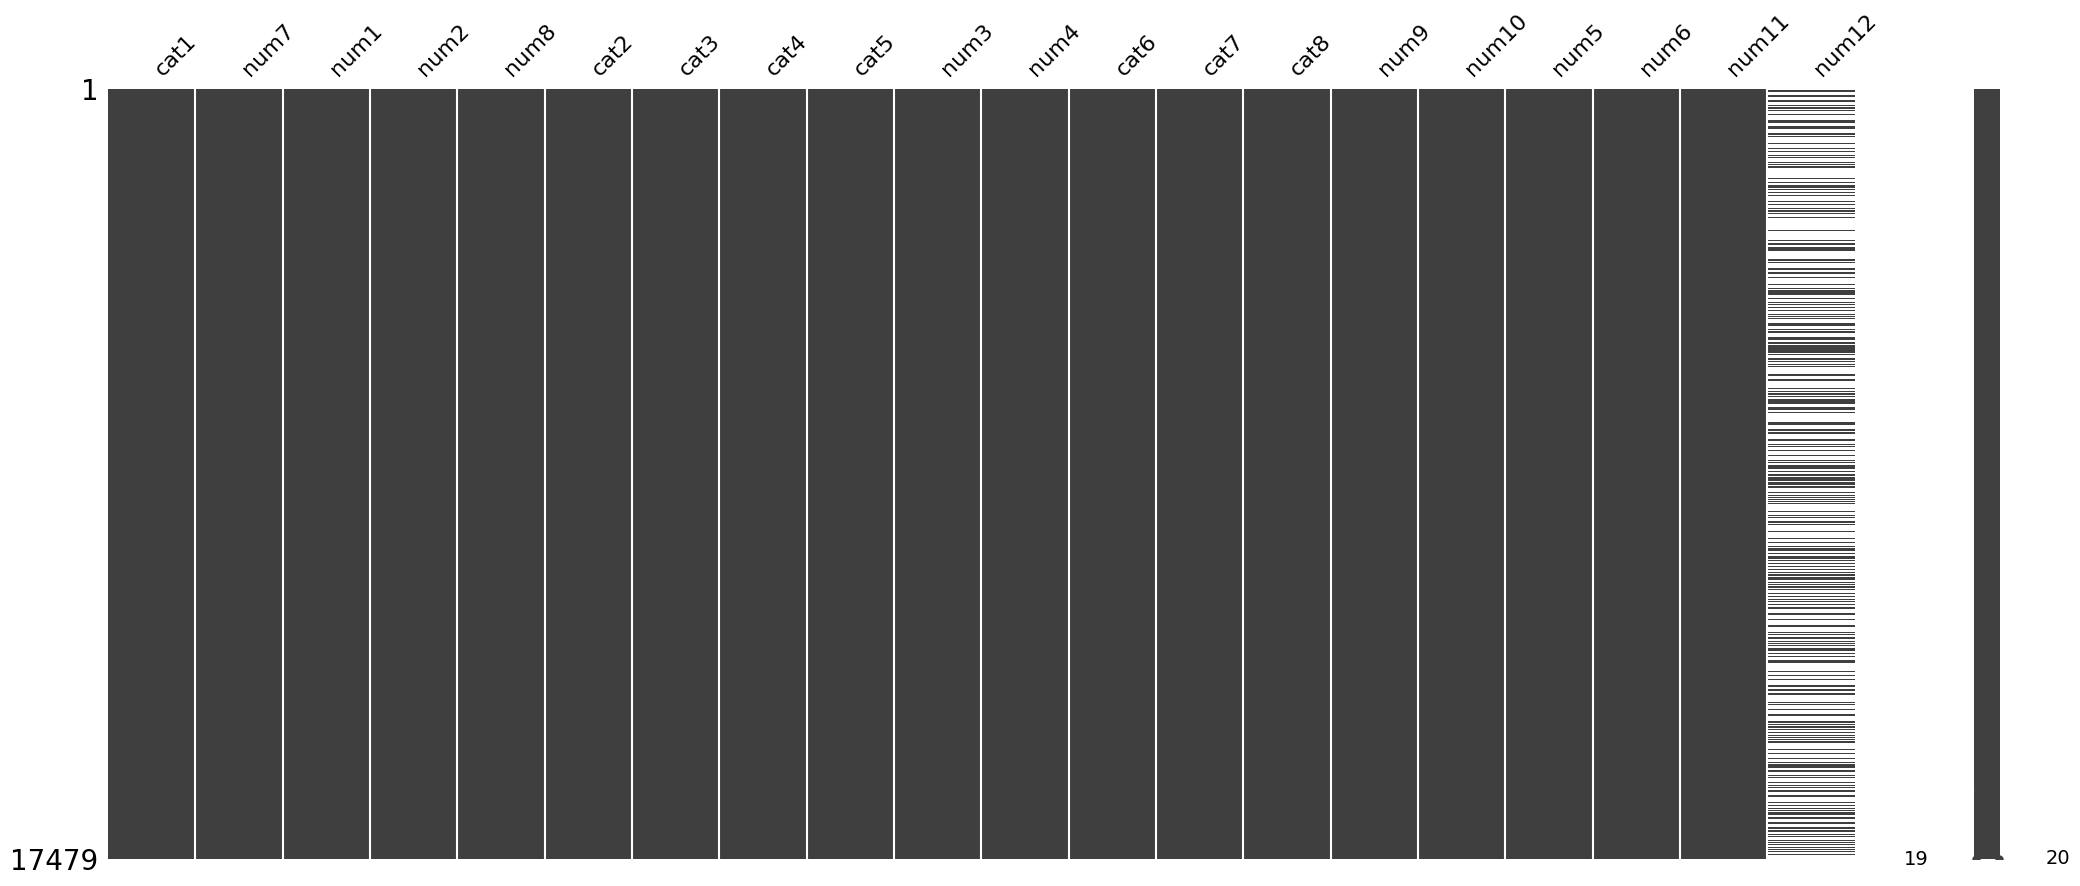

In [24]:
# Find the reasons for Missing Values
msno.matrix(X_train)

<Axes: >

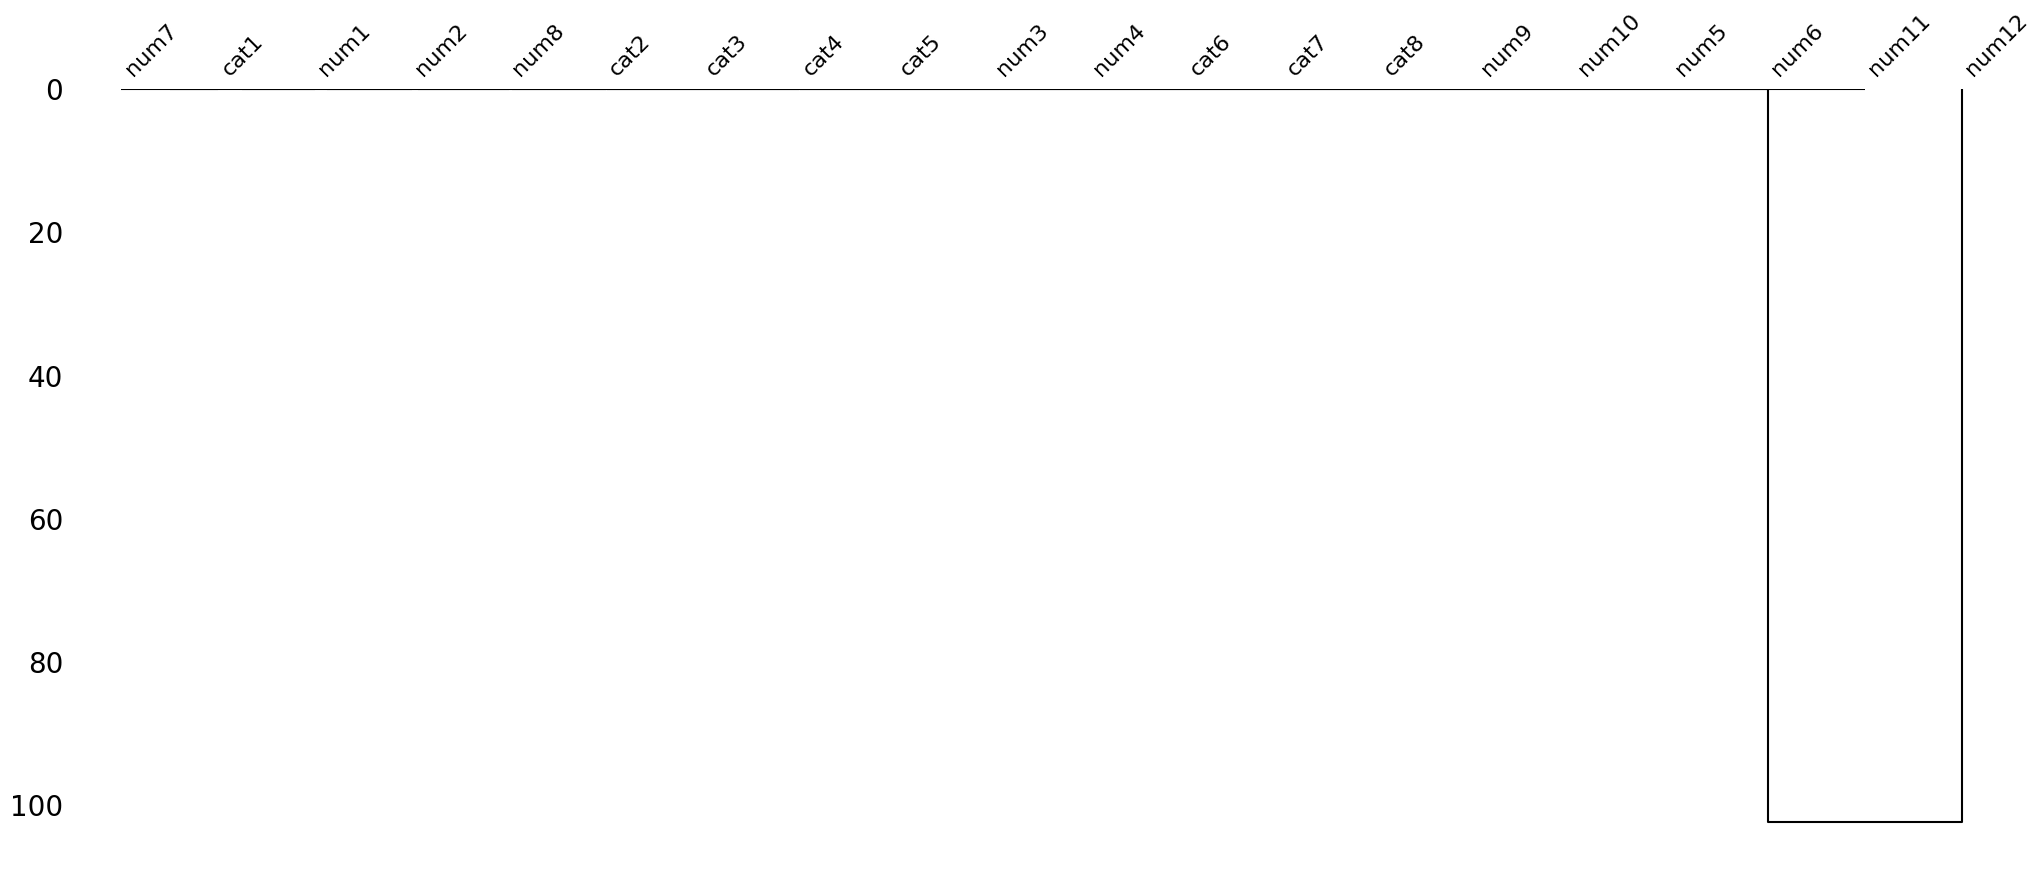

In [25]:
# Find the reasons for Missing Values
msno.dendrogram(X_train)

<Axes: >

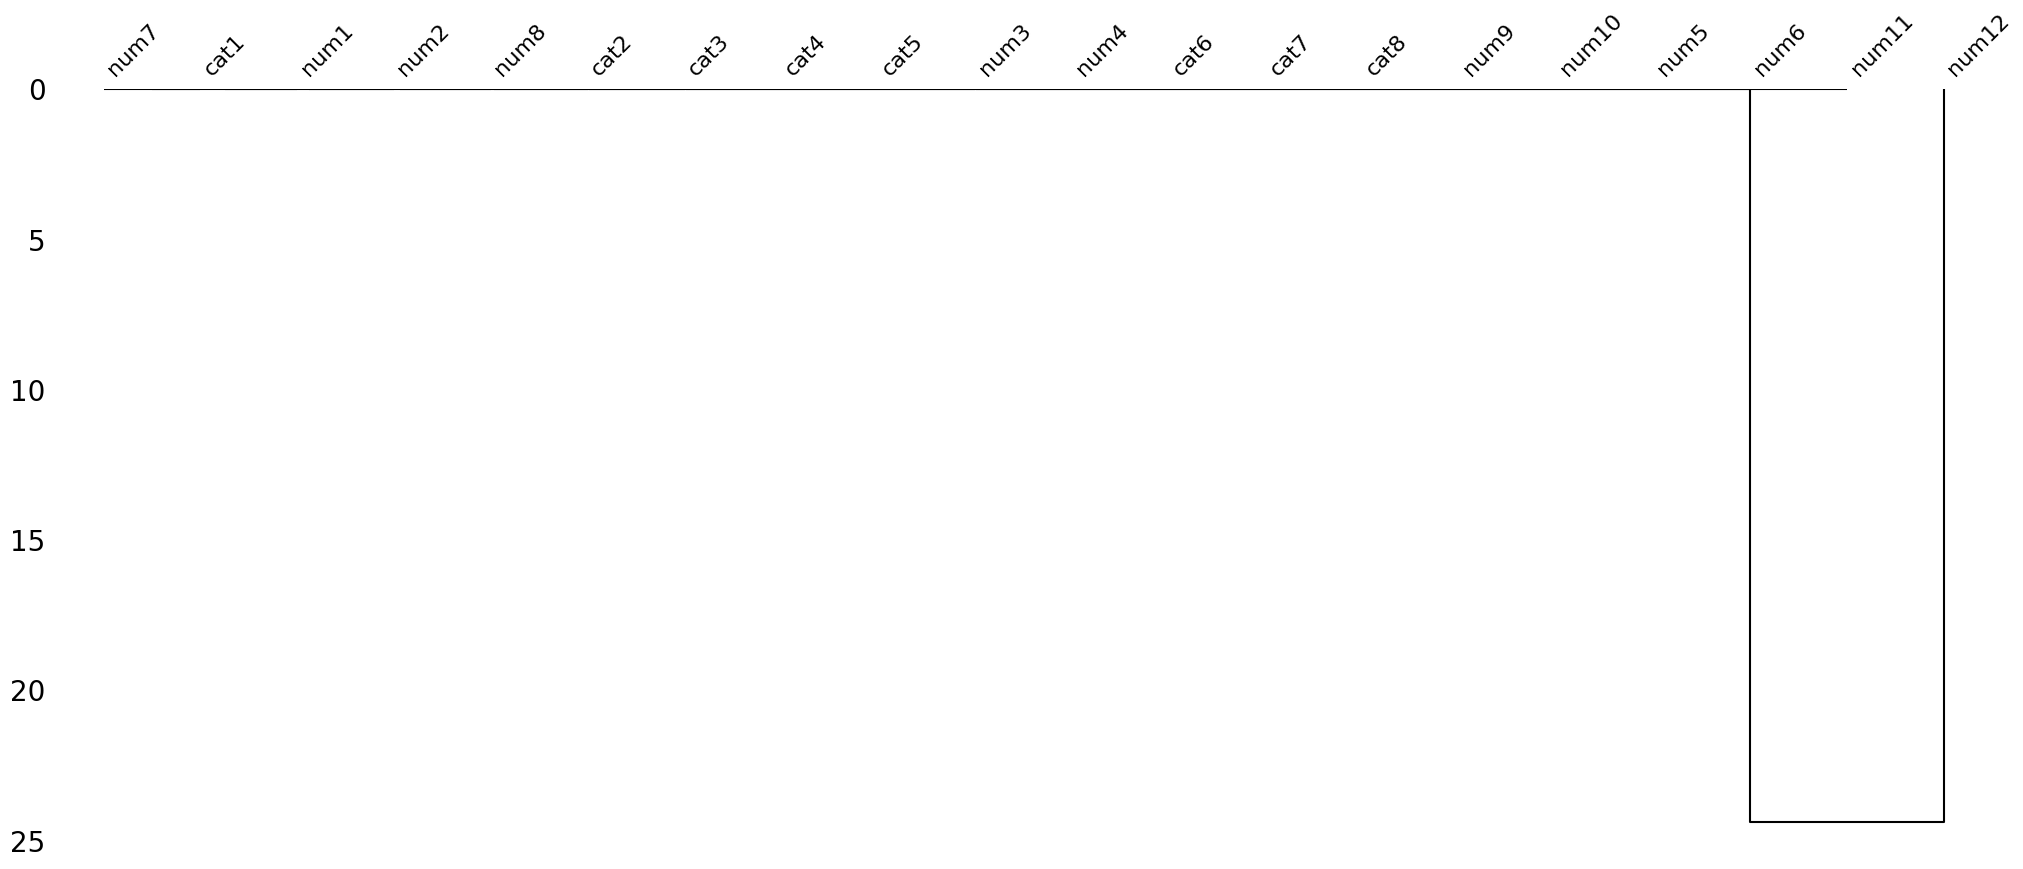

In [26]:
msno.dendrogram(X_public_test)

In [27]:
#Only select all row have num12 not null
X_train_12_6 = X_train.copy()[X_train['num12'].notna()][['num6', 'num12']]

In [28]:
imputer = IterativeImputer()
imputer.fit(X_train_12_6[['num6', 'num12']])

IterativeImputer()

In [29]:
X_train[['num6', 'num12']] = imputer.transform(X_train[['num6', 'num12']])
X_train

,cat1,num7,num1,num2,num8,cat2,cat3,cat4,cat5,num3,num4,cat6,cat7,cat8,num9,num10,num5,num6,num11,num12
0,18,3002.615162,6.844050e+05,5.438812e+05,1984.083468,3,2,23,66,5.906644e+05,1.497083e+05,14005,5,490516,5976.987619,-22722.298810,1.087513e+06,1.293984e+06,3.164912e+05,0.366733
1,23,1753.001446,9.696060e+05,3.536075e+06,1616.969212,3,2,35,58,9.573292e+05,1.422117e+03,13704,5,490281,5957.691379,-22690.811020,1.036992e+06,5.495982e+06,1.170566e+06,0.324751
2,23,2534.010019,1.518483e+06,5.372982e+06,1984.083468,3,2,23,66,1.499355e+06,1.422117e+03,13907,5,490461,5931.756421,-22698.585783,1.929520e+06,6.097910e+06,1.454420e+06,0.318737
3,28,2846.413447,1.238664e+06,1.468111e+06,1800.526340,3,2,23,50,7.128860e+05,8.911393e+05,13767,5,490721,5966.821025,-22715.495892,1.062252e+06,2.281633e+06,4.500649e+05,0.356865
4,33,2846.413447,1.486196e+06,3.328124e+06,1616.969212,3,2,23,58,7.607118e+05,1.234051e+06,13858,5,490361,5987.458534,-22684.785579,2.072662e+06,6.286102e+06,1.311595e+06,-74.511949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17474,28,3002.615162,1.308619e+06,3.347995e+06,1984.083468,3,2,23,66,1.292110e+06,1.422117e+03,14026,5,490191,5942.035726,-22659.323230,2.047402e+06,5.089430e+06,1.199939e+06,0.328813
17475,28,2690.211733,1.012655e+06,1.407507e+07,1984.083468,3,2,29,58,9.998411e+05,1.422117e+03,13627,9915,490211,5942.610556,-22673.512172,3.007290e+06,5.057825e+06,1.934031e+06,0.329129
17476,23,1753.001446,5.929254e+05,2.773586e+06,1800.526340,3,2,17,50,5.853504e+05,1.422117e+03,13487,5,490541,5961.715186,-22718.022690,8.096501e+05,4.224609e+06,9.090104e+05,0.337453
17477,33,3158.816876,1.986644e+06,5.709402e+06,1984.083468,3,2,35,74,1.961672e+06,1.422117e+03,13844,5,490776,5988.687092,-22712.969094,1.929520e+06,6.524574e+06,1.517678e+06,0.314475


In [30]:
X_public_test[['num6', 'num12']] = imputer.transform(X_public_test[['num6', 'num12']])
X_public_test

,cat1,num7,num1,num2,num8,cat2,cat3,cat4,cat5,num3,num4,cat6,cat7,cat8,num9,num10,num5,num6,num11,num12
0,23,1753.001446,6.359746e+05,2.796691e+06,1616.969212,3,2,23,50,4.365589e+05,3.350661e+05,13613,5,490891,5957.950616,-22704.611224,9.022709e+05,4.346718e+06,9.184199e+05,0.336233
1,23,2690.211733,1.346287e+06,2.395509e+07,1616.969212,3,2,23,74,8.032237e+05,9.189430e+05,14096,5,490136,5955.121553,-22654.075265,1.912680e+06,3.911197e+07,7.938478e+06,-0.011103
2,18,1753.001446,4.745401e+05,2.933015e+06,1616.969212,3,2,23,58,4.684428e+05,1.422117e+03,13438,5,490531,5962.413999,-22725.797453,1.213814e+06,4.558614e+06,1.031248e+06,0.334116
3,18,2690.211733,8.081714e+05,5.434191e+05,1984.083468,3,2,23,66,6.066063e+05,3.350661e+05,14103,5,490536,5977.607533,-22726.769298,1.306435e+06,1.092145e+06,2.913230e+05,94.494222
4,28,3315.018591,2.110410e+06,8.821746e+06,1616.969212,3,7,23,82,1.191144e+06,1.558427e+06,14040,5,490201,5967.136618,-22697.808307,3.200952e+06,9.876835e+06,2.302521e+06,65.193100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23,1753.001446,5.929254e+05,2.372470e+06,1616.969212,3,2,23,50,4.471868e+05,2.423872e+05,13641,5,490516,5981.236850,-22721.521334,1.079093e+06,3.687327e+06,8.155829e+05,-34.599896
996,23,2221.606590,1.023417e+06,2.927932e+06,1616.969212,3,12,23,66,7.713398e+05,4.184771e+05,13641,5,490526,5977.449737,-22709.859189,1.289595e+06,4.550712e+06,9.809774e+05,0.334195
997,28,2690.211733,1.895164e+06,3.130801e+06,2167.640596,3,2,23,74,1.409018e+06,8.077284e+05,14047,5,490681,5962.143491,-22732.211633,2.468405e+06,4.639780e+06,1.080032e+06,0.333305
998,28,2690.211733,1.653012e+06,3.328124e+06,1984.083468,3,2,23,66,1.632205e+06,1.422117e+03,14040,5,490296,5957.432142,-22683.036257,2.182123e+06,5.172752e+06,1.209896e+06,0.327980


In [31]:
X_private_test[['num6', 'num12']] = imputer.transform(X_private_test[['num6', 'num12']])
X_private_test

,cat1,num7,num1,num2,num8,cat2,cat3,cat4,cat5,num3,num4,cat6,cat7,cat8,num9,num10,num5,num6,num11,num12
0,18,2690.211733,8.458395e+05,5.868579e+05,2351.197725,3,2,23,58,8.351076e+05,1422.116564,14054,5,490531,5962.402727,-22727.158037,1.323275e+06,9.348392e+05,2.887917e+05,88.907338
1,23,2065.404875,6.090688e+05,3.328124e+06,1616.969212,3,2,23,58,6.012923e+05,1422.116564,13683,5,490891,5959.032648,-22705.388700,9.527914e+05,5.172752e+06,1.115149e+06,29.966569
2,33,3471.220305,2.271845e+06,4.270838e+06,1984.083468,3,12,35,90,1.818194e+06,742853.143055,13942,5,490201,5968.658226,-22700.723843,2.847309e+06,6.638064e+06,1.507085e+06,54.686102
3,23,2690.211733,9.211756e+05,7.698554e+05,1984.083468,3,2,35,66,6.916300e+05,381405.517641,14026,5,490996,5974.981351,-22730.656680,1.239074e+06,3.879829e+06,7.499133e+05,0.340898
4,28,2534.010019,1.782160e+06,5.898109e+07,1984.083468,3,2,35,74,1.759741e+06,1422.116564,13473,9785,490361,5984.719641,-22682.258781,3.226212e+06,3.157638e+07,8.849059e+06,52.187400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,23,2221.606590,8.727452e+05,2.542528e+06,1616.969212,3,2,23,58,5.906644e+05,474084.395952,13655,5,490561,5974.271268,-22716.078999,1.769539e+06,4.669949e+06,1.044536e+06,57.954467
2050,43,2065.404875,1.437766e+06,5.199689e+06,1800.526340,3,2,29,66,1.233656e+06,325798.190654,13641,5,490666,5982.476678,-22720.743857,1.710598e+06,6.465674e+06,1.462100e+06,-84.484032
2051,18,1753.001446,4.853024e+05,2.080413e+06,1616.969212,3,2,23,58,4.790707e+05,1422.116564,13662,5,490591,5961.647559,-22707.721129,9.906817e+05,3.822366e+06,8.322617e+05,60.137778
2052,28,2846.413447,2.083504e+06,4.643303e+06,1984.083468,3,2,23,90,2.057324e+06,1422.116564,14040,5,490166,5977.179229,-22693.337818,2.998870e+06,7.217006e+06,1.701940e+06,72.814790


### 2.2.3. Categorical features

In [32]:
X_full = pd.concat([
    X_train[CAT_FEATURES].assign(test='Train'),
    X_public_test[CAT_FEATURES].assign(test='Public test'),
    X_private_test[CAT_FEATURES].assign(test='Private test')
]).sort_index()

In [33]:
X_full

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,test
0,23,3,2,23,50,13613,5,490891,Public test
0,18,3,2,23,66,14005,5,490516,Train
0,18,3,2,23,58,14054,5,490531,Private test
1,23,3,2,23,74,14096,5,490136,Public test
1,23,3,2,35,58,13704,5,490281,Train
...,...,...,...,...,...,...,...,...,...
17474,28,3,2,23,66,14026,5,490191,Train
17475,28,3,2,29,58,13627,9915,490211,Train
17476,23,3,2,17,50,13487,5,490541,Train
17477,33,3,2,35,74,13844,5,490776,Train


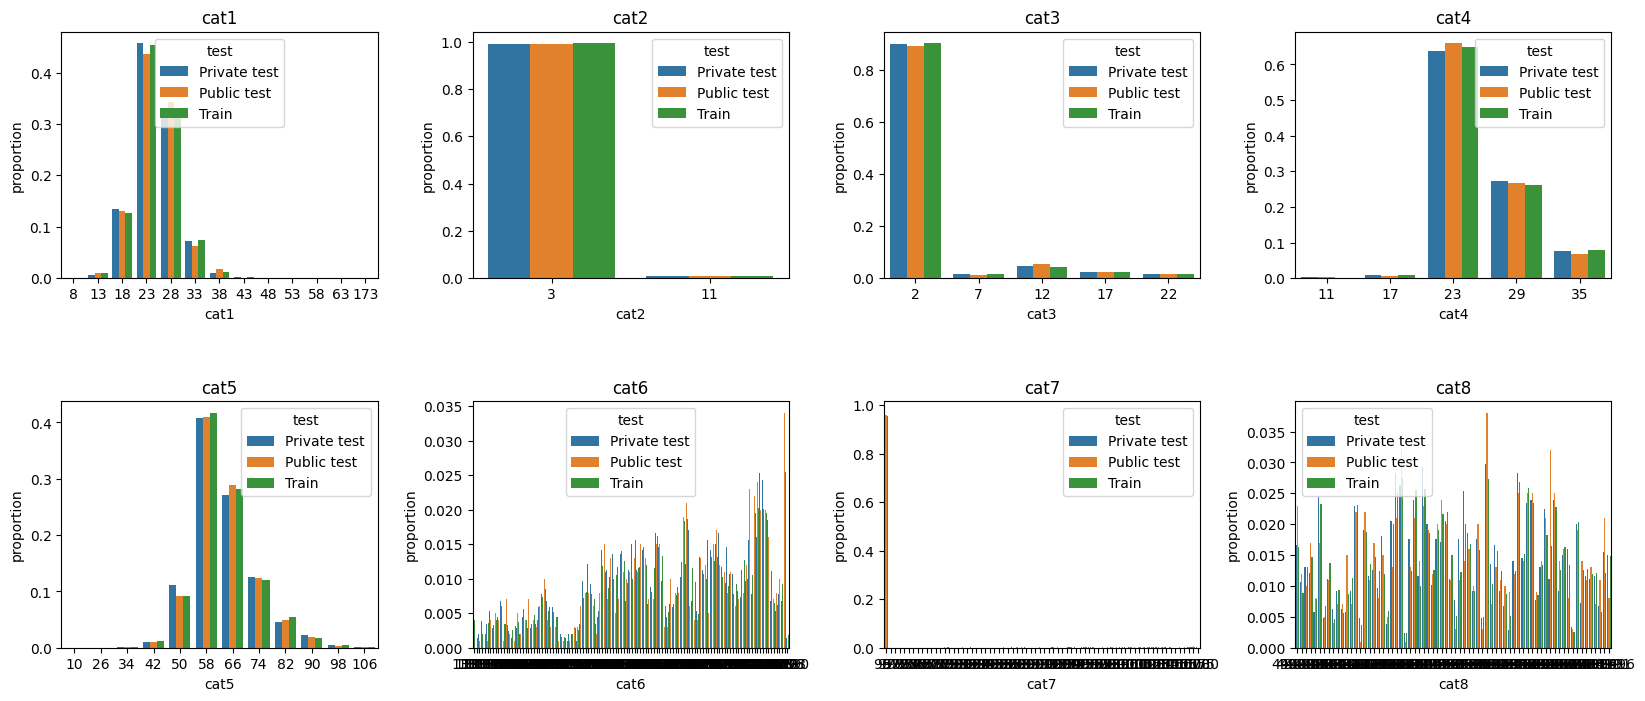

In [34]:
plt.figure(figsize=(20,8))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
#sns.set_palette("Spectral")
for i, col in enumerate(CAT_FEATURES):
    plt.subplot(2, 4, i+1)
    (X_full[col]
     .groupby(X_full['test'])
     .value_counts(normalize=True)
     .rename('proportion')
     .reset_index()
     .pipe((sns.barplot, "data"), x=col, y='proportion', hue='test'))
    plt.title(col)
plt.show()

Variables of categorical features on test and train data are distributed very similar

### 2.2.4. Continous features

In [35]:
X_train[NUM_FEATURES].describe()

,num7,num1,num2,num8,num3,num4,num9,num10,num5,num6,num11,num12
count,17479.000000,1.747900e+04,1.747900e+04,17479.000000,1.747900e+04,1.747900e+04,17479.000000,17479.000000,1.747900e+04,1.747900e+04,1.747900e+04,17479.000000
mean,2450.551708,1.121277e+06,7.035844e+06,1798.520538,9.508399e+05,2.739602e+05,5965.303092,-22697.717088,1.673793e+06,9.232685e+06,2.042349e+06,0.287418
std,483.263783,4.941025e+05,1.960372e+07,198.400012,4.391975e+05,4.114997e+05,15.597450,27.501530,5.773649e+05,1.991874e+07,4.157124e+06,36.473203
min,1128.194589,1.570521e+05,2.652259e+05,1616.969212,1.549178e+05,1.422117e+03,5919.786440,-22756.313398,3.372837e+05,4.686688e+05,1.642618e+05,-99.965749
25%,2065.404875,7.651222e+05,2.336194e+06,1616.969212,6.331762e+05,1.422117e+03,5955.256807,-22720.160750,1.255914e+06,3.664342e+06,8.562433e+05,0.222570
50%,2534.010019,1.034180e+06,3.515280e+06,1800.526340,8.297936e+05,1.422117e+03,5966.584331,-22700.723843,1.550617e+06,5.474434e+06,1.222615e+06,0.325081
75%,2690.211733,1.373192e+06,4.936977e+06,1984.083468,1.175203e+06,5.296917e+05,5978.576854,-22680.315090,1.988461e+06,7.252202e+06,1.620636e+06,0.355739
max,6126.649451,7.287078e+06,7.631185e+08,2534.754853,5.001270e+06,3.829060e+06,5989.859293,-22523.070510,5.230191e+06,6.257755e+08,1.267591e+08,99.975020


In [36]:
X_public_test[NUM_FEATURES].describe()

,num7,num1,num2,num8,num3,num4,num9,num10,num5,num6,num11,num12
count,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000
mean,2465.437466,1.117685e+06,7.421611e+06,1803.279697,9.530398e+05,2.639378e+05,5965.063411,-22698.512311,1.673521e+06,8.954393e+06,2.018507e+06,1.689738
std,475.673399,4.959796e+05,2.256539e+07,200.065731,4.353014e+05,4.026008e+05,15.588820,27.286489,5.538604e+05,1.904610e+07,3.991179e+06,37.407827
min,1596.799732,2.539129e+05,3.243766e+05,1616.969212,2.505695e+05,1.422117e+03,5924.204738,-22746.206206,3.886462e+05,5.821586e+05,1.935325e+05,-99.998314
25%,2221.606590,7.641805e+05,2.311471e+06,1616.969212,6.477897e+05,1.422117e+03,5954.749604,-22720.986819,1.255914e+06,3.617653e+06,8.472952e+05,0.266626
50%,2534.010019,1.018036e+06,3.476000e+06,1800.526340,8.244796e+05,1.422117e+03,5966.032044,-22704.514040,1.550617e+06,5.431336e+06,1.210591e+06,0.326782
75%,2690.211733,1.362430e+06,4.854605e+06,1984.083468,1.183173e+06,4.926202e+05,5978.565583,-22680.898197,2.029930e+06,7.112136e+06,1.567920e+06,0.367752
max,6126.649451,6.485286e+06,4.539262e+08,2351.197725,4.554896e+06,3.226647e+06,5989.848022,-22600.040663,4.009280e+06,2.778444e+08,4.640605e+07,99.943545


In [37]:
X_private_test[NUM_FEATURES].describe()

,num7,num1,num2,num8,num3,num4,num9,num10,num5,num6,num11,num12
count,2054.000000,2.054000e+03,2.054000e+03,2054.000000,2.054000e+03,2.054000e+03,2054.000000,2054.000000,2.054000e+03,2.054000e+03,2.054000e+03,2054.000000
mean,2441.003837,1.114159e+06,6.753962e+06,1797.756003,9.532915e+05,2.574261e+05,5965.575468,-22697.681976,1.680980e+06,9.033726e+06,1.995810e+06,-0.556076
std,472.567578,4.984842e+05,1.565859e+07,197.989575,4.475519e+05,4.031225e+05,15.792373,26.875336,5.890343e+05,1.807307e+07,3.746478e+06,47.867711
min,1596.799732,2.001013e+05,2.411959e+05,1616.969212,1.974296e+05,1.422117e+03,5923.945501,-22757.090874,5.823079e+05,4.744151e+05,1.749709e+05,-99.722352
25%,2221.606590,7.758845e+05,2.311471e+06,1616.969212,6.331762e+05,1.422117e+03,5955.761191,-22719.188905,1.255914e+06,3.664342e+06,8.462528e+05,-28.923362
50%,2534.010019,1.018036e+06,3.576741e+06,1800.526340,8.382960e+05,1.422117e+03,5967.119711,-22700.821027,1.559037e+06,5.515017e+06,1.232266e+06,0.324887
75%,2690.211733,1.367811e+06,4.989773e+06,1984.083468,1.164575e+06,4.833523e+05,5978.945985,-22680.509459,1.988461e+06,7.261181e+06,1.615035e+06,28.303002
max,5345.640878,5.403675e+06,2.963104e+08,2351.197725,4.081951e+06,4.468544e+06,5989.757853,-22599.263186,5.145990e+06,2.731518e+08,4.945358e+07,99.963589


## 2.3. Feature important (FI) model

In [38]:
N_ITER = 5
N_FOLDS = 3

train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.20, shuffle=True, random_state=SEED)
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

In [39]:
CONST_PARAMS = {
  'loss_function': 'RMSE',
  'task_type': "GPU",
  'eval_metric': 'RMSE',
  'leaf_estimation_method': 'Newton',
  'bootstrap_type': 'Bernoulli',
  'cat_features': CAT_FEATURES,
  'verbose': 0,
  'random_state': 48
}

In [40]:
def catboost_rmse_cv(params, random_state=SEED, cv=kf, X=train_x, y=train_y):
    # the function gets a set of variable parameters in "param"
    catboost_params = {
        **CONST_PARAMS,
        'iterations': params["iterations"],
        'od_wait': params['od_wait'],
        'learning_rate': params['learning_rate'],
        'reg_lambda': params['reg_lambda'],
        'subsample': params['subsample'],
        'random_strength': params['random_strength'],
        'depth': params['depth'],
        'min_data_in_leaf': params['min_data_in_leaf'],  # Slightly higher to prevent overfitting
        'leaf_estimation_iterations': params['leaf_estimation_iterations']
    }

    model = CatBoostRegressor(**catboost_params)

    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1).mean()

    return score

In [41]:
%%time
space = {
    'iterations': hp.randint("iterations", 200, 1000),
    'od_wait': hp.randint('od_wait', 20, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),  # Lower range for finer control
    'reg_lambda': hp.uniform('reg_lambda', 1e-3, 10),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'random_strength': hp.uniform('random_strength', 0.1, 10),
    'depth': hp.randint('depth', 6, 10),
    'min_data_in_leaf': hp.randint('min_data_in_leaf', 5, 20),  # Slightly higher to prevent overfitting
    'leaf_estimation_iterations': hp.randint('leaf_estimation_iterations', 1, 10),
}

# trials will contain logging information
trials = Trials()

best = fmin(
    fn=catboost_rmse_cv, # function to optimize
    space=space,
    algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
    max_evals=N_ITER, # maximum number of iterations
    trials=trials, # logging
    rstate=np.random.default_rng(SEED) # fixing random state for the reproducibility
)

# computing the score on the test set
model = CatBoostRegressor(
    **CONST_PARAMS,
    iterations = best["iterations"],
    od_wait = best['od_wait'],
    learning_rate = best['learning_rate'],
    reg_lambda = best['reg_lambda'],
    subsample = best['subsample'],
    random_strength = best['random_strength'],
    depth = best['depth'],
    min_data_in_leaf = best['min_data_in_leaf'],  # Slightly higher to prevent overfitting
    leaf_estimation_iterations = best['leaf_estimation_iterations']
)
model.fit(train_x, train_y)
tpe_test_score=mean_squared_error(val_y, model.predict(val_x))

print("Best RMSE {:.6f} with params {}".format(catboost_rmse_cv(best), best))

100%|██████████| 5/5 [03:38<00:00, 43.62s/trial, best loss: 122.83108033386173]
Best RMSE 122.831081 with params {'depth': 7, 'iterations': 494, 'leaf_estimation_iterations': 8, 'learning_rate': 0.09733047765763703, 'min_data_in_leaf': 18, 'od_wait': 49, 'random_strength': 9.807716267001531, 'reg_lambda': 4.131840880142331, 'subsample': 0.9373419327597992}
CPU times: user 5min 14s, sys: 35.6 s, total: 5min 49s
Wall time: 4min 33s


In [42]:
catboost_params = {
    'depth': 7, 
    'iterations': 494, 
    'leaf_estimation_iterations': 8, 
    'learning_rate': 0.09733047765763703, 
    'min_data_in_leaf': 18, 
    'od_wait': 49, 
    'random_strength': 9.807716267001531, 
    'reg_lambda': 4.131840880142331, 
    'subsample': 0.9373419327597992,
    'loss_function': 'RMSE',
    'task_type': "GPU",
    'eval_metric': 'RMSE',
    'leaf_estimation_method': 'Newton',
    'bootstrap_type': 'Bernoulli',
    'cat_features': CAT_FEATURES,
    'verbose': 0,
    'random_state': 48
}

In [43]:
N_FOLDS = 5

model_fi = 0
val_rmse = []

# CV starts here.
for fold, (train_idx, valid_idx) in enumerate(KFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True).split(X_train)):
    # Train model
    model = CatBoostRegressor(**catboost_params)
    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx], eval_set=(X_train.iloc[valid_idx], y_train.iloc[valid_idx]))

    # Predict on valid data
    predictions = model.predict(X_train.iloc[valid_idx])

    # Mean of feature importance
    model_fi += model.feature_importances_ / N_FOLDS

    # RMSE
    rmse = math.sqrt(mean_squared_error(y_train.iloc[valid_idx], predictions))
    val_rmse.append(rmse)
    print(f'Fold {fold} | RMSE: {rmse:.6f}')

print(f'\nFull CrossVal RMSE: {np.mean(val_rmse):.6f} (std: {np.std(val_rmse):.6f})')

Fold 0 | RMSE: 111.006786
Fold 1 | RMSE: 117.542252
Fold 2 | RMSE: 121.576492
Fold 3 | RMSE: 113.054144
Fold 4 | RMSE: 119.203540

Full CrossVal RMSE: 116.476643 (std: 3.904172)


In [44]:
feature_importance_X_train = pd.DataFrame(model_fi, index=X_train.columns)
feature_importance_X_train.sort_values(by=0, ascending=False)

,0
cat8,17.372353
cat5,17.319000
num9,10.425419
num1,10.169651
num10,9.715832
cat3,6.194485
cat2,4.346482
num3,4.141303
num7,3.336669
cat4,2.782930


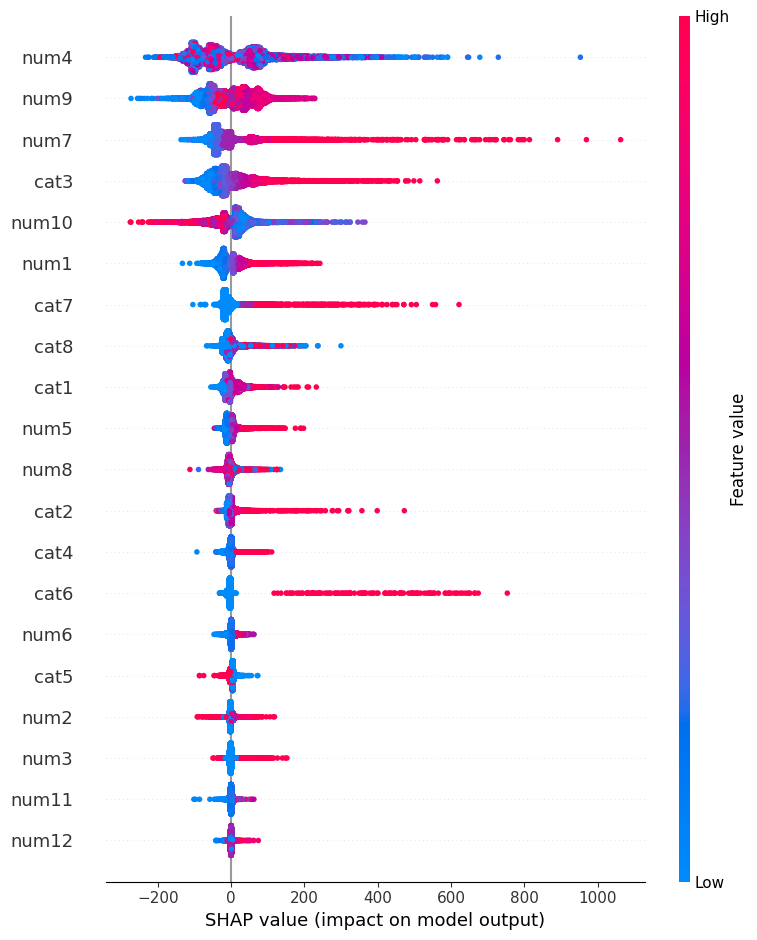

In [45]:
train_data = Pool(data=X_train.copy(),
                  label=y_train.copy(),
                  cat_features=CAT_FEATURES
                 )
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data)
shap.summary_plot(shap_values, X_train.copy(), feature_names=ALL_FEATURES)

## 2.4. Predict anomalies of wear_rate

In [46]:
y_train['wear_rate'].describe()

count    17479.000000
mean       539.783245
std        363.234680
min         75.000000
25%        324.000000
50%        450.000000
75%        642.000000
max       6885.000000
Name: wear_rate, dtype: float64

Quantile 75% is 642 but max is 6885. We have outliers at the bottom.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


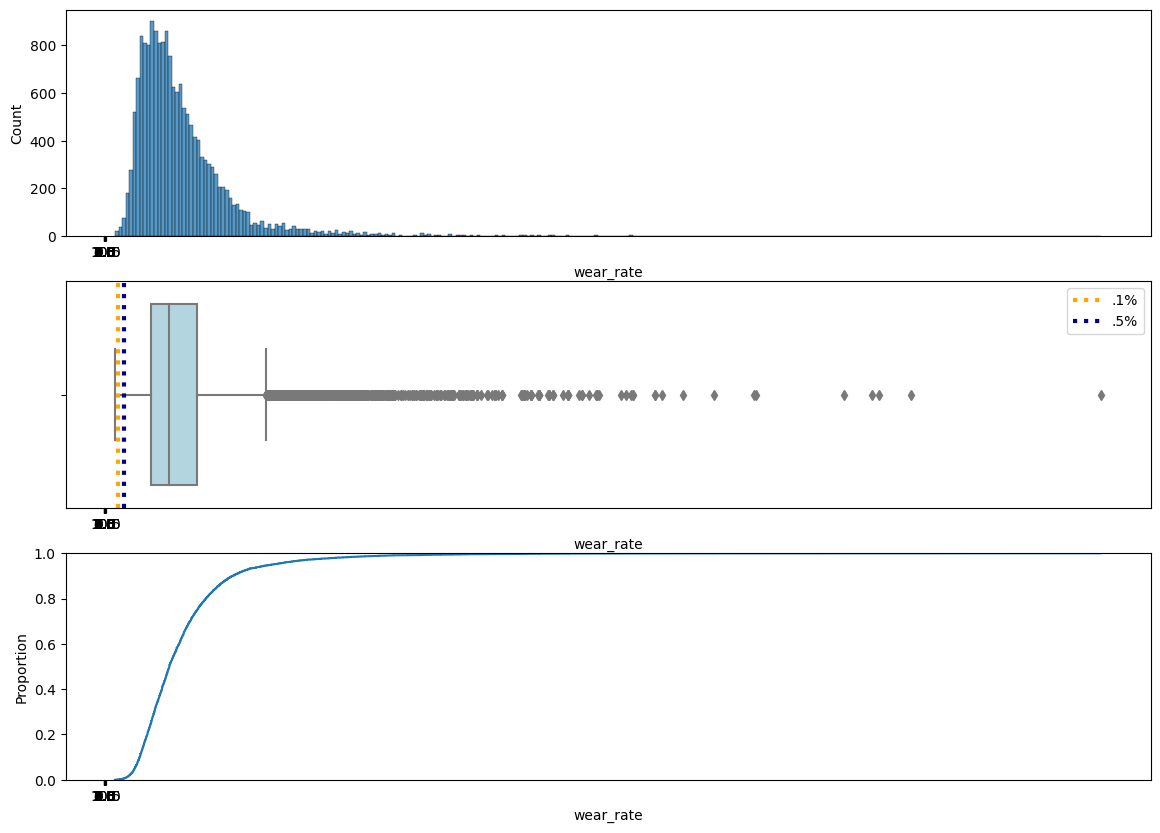

In [47]:
f,ax=plt.subplots(3,1,figsize=(14,10))
#plt.title('Target values', fontsize=16)
sns.histplot(y_train['wear_rate'], ax=ax[0])
sns.boxplot(x = y_train['wear_rate'], color='lightblue', saturation=0.8, ax=ax[1])
ax[1].axvline(np.percentile(y_train['wear_rate'],.1), label='.1%', c='orange', linestyle=':', linewidth=3)
ax[1].axvline(np.percentile(y_train['wear_rate'],.5), label='.5%', c='darkblue', linestyle=':', linewidth=3)
ax[1].legend()
sns.ecdfplot(y_train['wear_rate'], ax=ax[2])
ax[0].set_xticks(np.arange(0,10.8,.5))
ax[1].set_xticks(np.arange(0,10.8,.5))
ax[2].set_xticks(np.arange(0,10.8,.5))
plt.show()

In [48]:
print(f"Skew of wear_rate {y_train['wear_rate'].skew():.3f}")

Skew of wear_rate 3.694


```wear_rate``` has a strong left skewed distribution, but we have about some amount of otliers on the left tail (from 75 to 344)

## 2.5. Encoding categories

Apply one-hot encoding to categorical features cat3 and cat7

In [49]:
list_cat3 = set(X_train['cat3'].values)
list_cat3

{2, 7, 12, 17, 22}

In [50]:
list_cat7 = set(X_train['cat7'].values)
list_cat7

{5,
 9675,
 9705,
 9725,
 9730,
 9735,
 9745,
 9755,
 9760,
 9770,
 9775,
 9780,
 9785,
 9790,
 9795,
 9800,
 9805,
 9815,
 9820,
 9825,
 9830,
 9840,
 9845,
 9850,
 9855,
 9860,
 9865,
 9870,
 9875,
 9880,
 9885,
 9890,
 9895,
 9900,
 9905,
 9910,
 9915,
 9920,
 9925,
 9930,
 9935,
 9940,
 9945,
 9950,
 9955,
 9960,
 9965,
 9970,
 9975,
 9980,
 9985,
 9990,
 9995,
 10000,
 10005,
 10010,
 10015,
 10020,
 10025,
 10030,
 10035,
 10040,
 10045,
 10050,
 10055,
 10060,
 10065,
 10070,
 10075,
 10080}

In [51]:
X_train['cat3_2'] = X_train['cat3'].apply(lambda x: 1 if x == 2 else 0)
X_train['cat7_5'] = X_train['cat7'].apply(lambda x: 1 if x == 5 else 0)

X_public_test['cat3_2'] = X_public_test['cat3'].apply(lambda x: 1 if x == 2 else 0)
X_public_test['cat7_5'] = X_public_test['cat7'].apply(lambda x: 1 if x == 5 else 0)

X_private_test['cat3_2'] = X_private_test['cat3'].apply(lambda x: 1 if x == 2 else 0)
X_private_test['cat7_5'] = X_private_test['cat7'].apply(lambda x: 1 if x == 5 else 0)

In [52]:
X_train

,cat1,num7,num1,num2,num8,cat2,cat3,cat4,cat5,num3,...,cat7,cat8,num9,num10,num5,num6,num11,num12,cat3_2,cat7_5
0,18,3002.615162,6.844050e+05,5.438812e+05,1984.083468,3,2,23,66,5.906644e+05,...,5,490516,5976.987619,-22722.298810,1.087513e+06,1.293984e+06,3.164912e+05,0.366733,1,1
1,23,1753.001446,9.696060e+05,3.536075e+06,1616.969212,3,2,35,58,9.573292e+05,...,5,490281,5957.691379,-22690.811020,1.036992e+06,5.495982e+06,1.170566e+06,0.324751,1,1
2,23,2534.010019,1.518483e+06,5.372982e+06,1984.083468,3,2,23,66,1.499355e+06,...,5,490461,5931.756421,-22698.585783,1.929520e+06,6.097910e+06,1.454420e+06,0.318737,1,1
3,28,2846.413447,1.238664e+06,1.468111e+06,1800.526340,3,2,23,50,7.128860e+05,...,5,490721,5966.821025,-22715.495892,1.062252e+06,2.281633e+06,4.500649e+05,0.356865,1,1
4,33,2846.413447,1.486196e+06,3.328124e+06,1616.969212,3,2,23,58,7.607118e+05,...,5,490361,5987.458534,-22684.785579,2.072662e+06,6.286102e+06,1.311595e+06,-74.511949,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17474,28,3002.615162,1.308619e+06,3.347995e+06,1984.083468,3,2,23,66,1.292110e+06,...,5,490191,5942.035726,-22659.323230,2.047402e+06,5.089430e+06,1.199939e+06,0.328813,1,1
17475,28,2690.211733,1.012655e+06,1.407507e+07,1984.083468,3,2,29,58,9.998411e+05,...,9915,490211,5942.610556,-22673.512172,3.007290e+06,5.057825e+06,1.934031e+06,0.329129,1,0
17476,23,1753.001446,5.929254e+05,2.773586e+06,1800.526340,3,2,17,50,5.853504e+05,...,5,490541,5961.715186,-22718.022690,8.096501e+05,4.224609e+06,9.090104e+05,0.337453,1,1
17477,33,3158.816876,1.986644e+06,5.709402e+06,1984.083468,3,2,35,74,1.961672e+06,...,5,490776,5988.687092,-22712.969094,1.929520e+06,6.524574e+06,1.517678e+06,0.314475,1,1


In [53]:
EXTRA_FEATURES = ['cat3_2', 'cat7_5']
ALL_FEATURES += EXTRA_FEATURES
CAT_FEATURES += EXTRA_FEATURES
print(CAT_FEATURES)

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat3_2', 'cat7_5']


Ordinal encode of categorical columns

In [54]:
ordinal_encoder = OrdinalEncoder()
X_train[CAT_FEATURES] = ordinal_encoder.fit_transform(X_train[CAT_FEATURES]).astype(int)
X_public_test[CAT_FEATURES] = ordinal_encoder.transform(X_public_test[CAT_FEATURES]).astype(int)
X_private_test[CAT_FEATURES] = ordinal_encoder.transform(X_private_test[CAT_FEATURES]).astype(int)

In [55]:
X_train

,cat1,num7,num1,num2,num8,cat2,cat3,cat4,cat5,num3,...,cat7,cat8,num9,num10,num5,num6,num11,num12,cat3_2,cat7_5
0,2,3002.615162,6.844050e+05,5.438812e+05,1984.083468,0,0,2,6,5.906644e+05,...,0,42,5976.987619,-22722.298810,1.087513e+06,1.293984e+06,3.164912e+05,0.366733,1,1
1,3,1753.001446,9.696060e+05,3.536075e+06,1616.969212,0,0,4,5,9.573292e+05,...,0,31,5957.691379,-22690.811020,1.036992e+06,5.495982e+06,1.170566e+06,0.324751,1,1
2,3,2534.010019,1.518483e+06,5.372982e+06,1984.083468,0,0,2,6,1.499355e+06,...,0,40,5931.756421,-22698.585783,1.929520e+06,6.097910e+06,1.454420e+06,0.318737,1,1
3,4,2846.413447,1.238664e+06,1.468111e+06,1800.526340,0,0,2,4,7.128860e+05,...,0,59,5966.821025,-22715.495892,1.062252e+06,2.281633e+06,4.500649e+05,0.356865,1,1
4,5,2846.413447,1.486196e+06,3.328124e+06,1616.969212,0,0,2,5,7.607118e+05,...,0,36,5987.458534,-22684.785579,2.072662e+06,6.286102e+06,1.311595e+06,-74.511949,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17474,4,3002.615162,1.308619e+06,3.347995e+06,1984.083468,0,0,2,6,1.292110e+06,...,0,23,5942.035726,-22659.323230,2.047402e+06,5.089430e+06,1.199939e+06,0.328813,1,1
17475,4,2690.211733,1.012655e+06,1.407507e+07,1984.083468,0,0,3,5,9.998411e+05,...,36,26,5942.610556,-22673.512172,3.007290e+06,5.057825e+06,1.934031e+06,0.329129,1,0
17476,3,1753.001446,5.929254e+05,2.773586e+06,1800.526340,0,0,1,4,5.853504e+05,...,0,46,5961.715186,-22718.022690,8.096501e+05,4.224609e+06,9.090104e+05,0.337453,1,1
17477,5,3158.816876,1.986644e+06,5.709402e+06,1984.083468,0,0,4,7,1.961672e+06,...,0,62,5988.687092,-22712.969094,1.929520e+06,6.524574e+06,1.517678e+06,0.314475,1,1


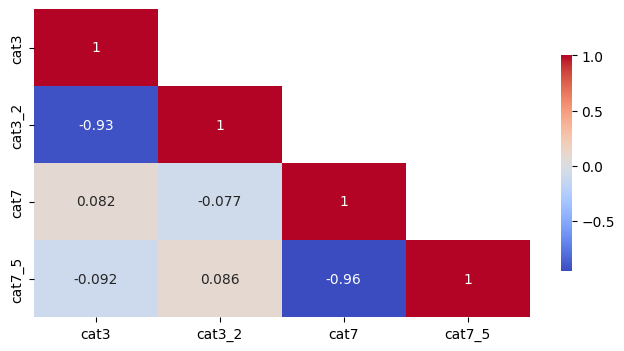

In [56]:
corrMatrix = X_train[['cat3', 'cat3_2', 'cat7', 'cat7_5']].corr(method='pearson', min_periods=1)
plt.figure(figsize=(8,4))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool), k=1)
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .7}, cmap='coolwarm')
plt.show()

Remove cat3 and cat7 due strong correlation with derived features

In [57]:
CAT_FEATURES.remove('cat3')
ALL_FEATURES.remove('cat3')
CAT_FEATURES.remove('cat7')
ALL_FEATURES.remove('cat7')

In [58]:
X_train[ALL_FEATURES].head()

,cat1,cat2,cat4,cat5,cat6,cat8,num7,num1,num2,num8,num3,num4,num9,num10,num5,num6,num11,num12,cat3_2,cat7_5
0,2,0,2,6,100,42,3002.615162,6.844050e+05,5.438812e+05,1984.083468,5.906644e+05,1.497083e+05,5976.987619,-22722.298810,1.087513e+06,1.293984e+06,3.164912e+05,0.366733,1,1
1,3,0,4,5,57,31,1753.001446,9.696060e+05,3.536075e+06,1616.969212,9.573292e+05,1.422117e+03,5957.691379,-22690.811020,1.036992e+06,5.495982e+06,1.170566e+06,0.324751,1,1
2,3,0,2,6,86,40,2534.010019,1.518483e+06,5.372982e+06,1984.083468,1.499355e+06,1.422117e+03,5931.756421,-22698.585783,1.929520e+06,6.097910e+06,1.454420e+06,0.318737,1,1
3,4,0,2,4,66,59,2846.413447,1.238664e+06,1.468111e+06,1800.526340,7.128860e+05,8.911393e+05,5966.821025,-22715.495892,1.062252e+06,2.281633e+06,4.500649e+05,0.356865,1,1
4,5,0,2,5,79,36,2846.413447,1.486196e+06,3.328124e+06,1616.969212,7.607118e+05,1.234051e+06,5987.458534,-22684.785579,2.072662e+06,6.286102e+06,1.311595e+06,-74.511949,1,1


# 3- Model

## 3.1. Split data

In [59]:
SUBMISSION_MODE = 0 # 0: Not submit, 1: Submit public, 2: Submit private

In [60]:
if SUBMISSION_MODE == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
if SUBMISSION_MODE == 1:
    X_test = X_public_test
if SUBMISSION_MODE == 2:
    X_test = X_private_test

In [61]:
# y_train = y_train['wear_rate']
# if SUBMISSION_MODE == 0:
#   y_test = y_test['wear_rate']

In [62]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
if (SUBMISSION_MODE == 0):
  print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (14857, 22)
Shape of y_train: (14857, 1)
Shape of X_test: (2622, 22)
Shape of y_test: (2622, 1)


## 3.2. Helper function

In [63]:
model_results = {'model': [], 'score': [], 'training_time': []}
N_FOLD = 5

def add_model_result(dic, model, score, time=None):
    dic['model'].append(model)
    dic['score'].append(score)
    if time:
        dic['training_time'].append(time)

In [64]:
class ContinuousTargetStratifiedKFold:
    """
    Obtain stratified cross validation splits from the continuous targets
    -------
    Parameters
    -------
    - n_splits(int): Number of folds
    - nbins(int): The criteria to bin by(from pd.cut)
    - shuffle(bool): Whether to shuffle
    - random_state(int):
    -------
    Examples
    -------
    >>> cskf = ContinuousTargetStratifiedKFold(n_splits=n_s)
    >>> for fold_no, (t, v) in enumerate(skf.split(target, target)):
            pass
    -------
    Sources
    -------
    - [Continuous Target Stratification](https://www.kaggle.com/tolgadincer/continuous-target-stratification)
    - [How to generate a custom cross-validation generator in scikit-learn?](https://stackoverflow.com/questions/30040597/how-to-generate-a-custom-cross-validation-generator-in-scikit-learn/39721727)
    """
    def __init__(self, n_splits=N_FOLD, nbins=100, shuffle=False, random_state=None):
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        self.nbins = nbins
        self.n_splits = n_splits

    def split(self, X, y):
        y = pd.qcut(y.rank(method='first'), self.nbins, labels=False) # implortant to use qcut
        for train_index, test_index in self.skf.split(y, y):
            yield train_index, test_index

    def get_n_splits(self, X=None, y=None):
        return self.n_splits

## 3.3. Tuning parameter (Level 0 stacking)

### 3.3.1. LGBMRegressor

In [61]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    param = {
        'metric': 'rmse',
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
        'early_stopping_rounds': 100,
        'verbose': -1,
        'device': "gpu"
    }
    model = LGBMRegressor(**param)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)])
    preds = model.predict(test_x)
    rmse = math.sqrt(mean_squared_error(test_y, preds))
    return rmse

#### Run time 1

In [62]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_lgbm_1 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm_1.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_lgbm_1.trials))
print('Best trial:', study_lgbm_1.best_trial.params)

[I 2025-03-02 13:37:34,825] A new study created in memory with name: no-name-240b6ad8-18ff-478d-9b93-4f3ea4646148
[I 2025-03-02 13:37:48,701] Trial 0 finished with value: 121.5327876231044 and parameters: {'reg_alpha': 0.006368166128613094, 'reg_lambda': 0.020705316141713552, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 191, 'min_child_samples': 141, 'cat_smooth': 66}. Best is trial 0 with value: 121.5327876231044.
[I 2025-03-02 13:38:16,050] Trial 1 finished with value: 119.81274950879511 and parameters: {'reg_alpha': 0.0010780554142953952, 'reg_lambda': 0.0018702516133869496, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 143, 'min_child_samples': 185, 'cat_smooth': 48}. Best is trial 1 with value: 119.81274950879511.
[I 2025-03-02 13:38:52,441] Trial 2 finished with value: 116.64911540305485 and parameters: {'reg_alpha': 6.361934668225038, 'reg_lambda': 0.0270188315736964, 'cols

Number of finished trials: 100
Best trial: {'reg_alpha': 0.0033990909031278655, 'reg_lambda': 1.8522685907607055, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 21, 'min_child_samples': 26, 'cat_smooth': 39}


In [63]:
optuna.visualization.plot_optimization_history(study_lgbm_1)

In [109]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_lgbm_1)

In [65]:
params=study_lgbm_1.best_params
params['random_state'] = 48
params['n_estimators'] = 20000
params['metric'] = 'rmse'
params['early_stopping_rounds'] = 100
params['verbose'] = -1
params['device'] = 'gpu'
params

{'reg_alpha': 0.0033990909031278655,
 'reg_lambda': 1.8522685907607055,
 'colsample_bytree': 0.3,
 'subsample': 0.6,
 'learning_rate': 0.01,
 'max_depth': 20,
 'num_leaves': 21,
 'min_child_samples': 26,
 'cat_smooth': 39,
 'random_state': 48,
 'n_estimators': 20000,
 'metric': 'rmse',
 'early_stopping_rounds': 100,
 'verbose': -1,
 'device': 'gpu'}

#### Run time 2

In [66]:
sampler = optuna.samplers.TPESampler(seed = SEED * 2)
study_lgbm_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm_2.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_lgbm_2.trials))
print('Best trial:', study_lgbm_2.best_trial.params)

[I 2025-03-02 14:00:15,569] A new study created in memory with name: no-name-101e4912-b451-4de7-8fec-4053ae40ad9a
[I 2025-03-02 14:00:21,970] Trial 0 finished with value: 108.36024931926566 and parameters: {'reg_alpha': 3.20825428360412, 'reg_lambda': 0.0017842424482014806, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 668, 'min_child_samples': 68, 'cat_smooth': 52}. Best is trial 0 with value: 108.36024931926566.
[I 2025-03-02 14:00:41,883] Trial 1 finished with value: 122.8465504957361 and parameters: {'reg_alpha': 0.22502106966011695, 'reg_lambda': 0.06418144641234771, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 927, 'min_child_samples': 272, 'cat_smooth': 68}. Best is trial 0 with value: 108.36024931926566.
[I 2025-03-02 14:01:05,447] Trial 2 finished with value: 106.20664582142878 and parameters: {'reg_alpha': 0.5315794444561702, 'reg_lambda': 2.238551253916649, 'colsample_bytr

Number of finished trials: 100
Best trial: {'reg_alpha': 6.840206764333904, 'reg_lambda': 1.8850359626807356, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 655, 'min_child_samples': 44, 'cat_smooth': 93}


In [67]:
optuna.visualization.plot_optimization_history(study_lgbm_2)

In [110]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_lgbm_2)

In [69]:
params=study_lgbm_2.best_params
params['random_state'] = 48
params['n_estimators'] = 20000
params['metric'] = 'rmse'
params['early_stopping_rounds'] = 100
params['verbose'] = -1
params['device'] = 'gpu'
params

{'reg_alpha': 6.840206764333904,
 'reg_lambda': 1.8850359626807356,
 'colsample_bytree': 0.4,
 'subsample': 0.7,
 'learning_rate': 0.02,
 'max_depth': 10,
 'num_leaves': 655,
 'min_child_samples': 44,
 'cat_smooth': 93,
 'random_state': 48,
 'n_estimators': 20000,
 'metric': 'rmse',
 'early_stopping_rounds': 100,
 'verbose': -1,
 'device': 'gpu'}

### 3.3.2. XGBRegressor

#### Run time 1

In [70]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1000, 12000, step=100),
        "max_depth":trial.suggest_int("max_depth", 1, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 100.),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 100.),
        "early_stopping_rounds": 300,
        "random_state": 48,
        "tree_method": "hist",
        "device": "cuda"
    }
    model = XGBRegressor(**params)
    model.fit(cp.asarray(train_x.copy()), cp.asarray(train_y.copy()), eval_set=[(cp.asarray(test_x.copy()), cp.asarray(test_y.copy()))],verbose=False)

    y_hat = model.predict(cp.asarray(test_x.copy()))

    return math.sqrt(mean_squared_error(test_y, y_hat))

In [71]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_xgb_1 = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb_1.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_xgb_1.trials))
print('Best trial:', study_xgb_1.best_trial.params)

[I 2025-03-02 14:19:23,342] A new study created in memory with name: no-name-7e2761c1-2554-4f37-8fa3-f882a8a7062f
[I 2025-03-02 14:19:28,119] Trial 0 finished with value: 195.51861370723663 and parameters: {'n_estimators': 3200, 'max_depth': 2, 'learning_rate': 0.0007753522760582496, 'gamma': 0.1, 'min_child_weight': 3, 'subsample': 0.7801781924895639, 'colsample_bytree': 0.6871264695281681, 'reg_alpha': 50.48501000883692, 'reg_lambda': 94.73306861314211}. Best is trial 0 with value: 195.51861370723663.
[I 2025-03-02 14:19:44,408] Trial 1 finished with value: 170.49501099220652 and parameters: {'n_estimators': 7900, 'max_depth': 5, 'learning_rate': 0.0001691857312634608, 'gamma': 0.4, 'min_child_weight': 3, 'subsample': 0.7681637076248855, 'colsample_bytree': 0.9255857890397091, 'reg_alpha': 8.090670967272382, 'reg_lambda': 6.283324147913396}. Best is trial 1 with value: 170.49501099220652.
[I 2025-03-02 14:19:57,041] Trial 2 finished with value: 241.37637887822544 and parameters: {'n_

Number of finished trials: 100
Best trial: {'n_estimators': 9800, 'max_depth': 4, 'learning_rate': 0.028462945898098668, 'gamma': 0.7000000000000001, 'min_child_weight': 1, 'subsample': 0.5618615123924947, 'colsample_bytree': 0.445629166102059, 'reg_alpha': 22.774672241805973, 'reg_lambda': 45.10412470345297}


In [72]:
optuna.visualization.plot_optimization_history(study_xgb_1)

In [111]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_xgb_1)

In [74]:
params=study_xgb_1.best_params
params['random_state'] = 48
params['early_stopping_rounds'] = 300
params['tree_method'] = 'hist'
params['device'] = 'cuda'
params

{'n_estimators': 9800,
 'max_depth': 4,
 'learning_rate': 0.028462945898098668,
 'gamma': 0.7000000000000001,
 'min_child_weight': 1,
 'subsample': 0.5618615123924947,
 'colsample_bytree': 0.445629166102059,
 'reg_alpha': 22.774672241805973,
 'reg_lambda': 45.10412470345297,
 'random_state': 48,
 'early_stopping_rounds': 300,
 'tree_method': 'hist',
 'device': 'cuda'}

#### Run time 2

In [75]:
sampler = optuna.samplers.TPESampler(seed = SEED * 2)
study_xgb_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb_2.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_xgb_2.trials))
print('Best trial:', study_xgb_2.best_trial.params)

[I 2025-03-02 14:36:43,450] A new study created in memory with name: no-name-4e76a615-ccd0-4db3-b215-0fa6d2057854
[I 2025-03-02 14:36:54,543] Trial 0 finished with value: 226.25216877841643 and parameters: {'n_estimators': 10700, 'max_depth': 1, 'learning_rate': 0.00022897812014581546, 'gamma': 0.8, 'min_child_weight': 7, 'subsample': 0.41750744257701344, 'colsample_bytree': 0.8868923630341452, 'reg_alpha': 45.88151923942156, 'reg_lambda': 63.879813670837926}. Best is trial 0 with value: 226.25216877841643.
[I 2025-03-02 14:37:11,003] Trial 1 finished with value: 182.4923560519422 and parameters: {'n_estimators': 9600, 'max_depth': 4, 'learning_rate': 0.00024041514727923883, 'gamma': 1.0, 'min_child_weight': 5, 'subsample': 0.23680672892931992, 'colsample_bytree': 0.6587200861989428, 'reg_alpha': 33.606713579687934, 'reg_lambda': 76.2811374393187}. Best is trial 1 with value: 182.4923560519422.
[I 2025-03-02 14:37:14,118] Trial 2 finished with value: 129.06866713870932 and parameters: 

Number of finished trials: 100
Best trial: {'n_estimators': 7500, 'max_depth': 5, 'learning_rate': 0.07951860004149862, 'gamma': 0.2, 'min_child_weight': 3, 'subsample': 0.69506520915565, 'colsample_bytree': 0.23770834966341048, 'reg_alpha': 95.70485383354658, 'reg_lambda': 2.7125557634168302}


In [76]:
optuna.visualization.plot_optimization_history(study_xgb_2)

In [112]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_xgb_2)

In [78]:
params=study_xgb_2.best_params
params['random_state'] = 48
params['early_stopping_rounds'] = 300
params['tree_method'] = 'hist'
params['device'] = 'cuda'
params

{'n_estimators': 7500,
 'max_depth': 5,
 'learning_rate': 0.07951860004149862,
 'gamma': 0.2,
 'min_child_weight': 3,
 'subsample': 0.69506520915565,
 'colsample_bytree': 0.23770834966341048,
 'reg_alpha': 95.70485383354658,
 'reg_lambda': 2.7125557634168302,
 'random_state': 48,
 'early_stopping_rounds': 300,
 'tree_method': 'hist',
 'device': 'cuda'}

#### Run time 3

In [79]:
xgboost_params = {
    'n_estimators': 7500,
    'max_depth': 5,
    'learning_rate': 0.07951860004149862,
    'gamma': 0.2,
    'min_child_weight': 3,
    'subsample': 0.69506520915565,
    'colsample_bytree': 0.23770834966341048,
    'reg_alpha': 95.70485383354658,
    'reg_lambda': 2.7125557634168302,
    'random_state': 48,
    'early_stopping_rounds': 300,
    'tree_method': 'hist',
    'device': 'cuda'
}

In [80]:
N_FOLDS = 5

model_fi = 0
val_rmse = []

# CV starts here.
for fold, (train_idx, valid_idx) in enumerate(KFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True).split(X_train)):
    # Train model
    model = XGBRegressor(**xgboost_params)
    model.fit(cp.asarray(X_train.iloc[train_idx].copy()), cp.asarray(y_train.iloc[train_idx].copy()), 
            eval_set=[(cp.asarray(X_train.iloc[valid_idx].copy()), cp.asarray(y_train.iloc[valid_idx].copy()))], verbose = False)

    # Predict on valid data
    predictions = model.predict(cp.asarray(X_train.iloc[valid_idx].copy()))

    # Mean of feature importance
    model_fi += model.feature_importances_ / N_FOLDS

    # RMSE
    rmse = math.sqrt(mean_squared_error(y_train.iloc[valid_idx], predictions))
    val_rmse.append(rmse)
    print(f'Fold {fold} | RMSE: {rmse:.6f}')

print(f'\nFull CrossVal RMSE: {np.mean(val_rmse):.6f} (std: {np.std(val_rmse):.6f})')

Fold 0 | RMSE: 117.484586
Fold 1 | RMSE: 109.054168
Fold 2 | RMSE: 125.745160
Fold 3 | RMSE: 122.466486
Fold 4 | RMSE: 121.560854

Full CrossVal RMSE: 119.262251 (std: 5.743585)


In [81]:
feature_importance_X_train = pd.DataFrame(model_fi, index=X_train.columns)
feature_importance_X_train.sort_values(by=0, ascending=False)

,0
cat5,0.262097
cat2,0.122315
cat3,0.122172
num1,0.103372
num8,0.052144
num9,0.048048
cat3_2,0.040514
cat8,0.040236
num7,0.028200
num10,0.022719


In [82]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1000, 12000, step=100),
        "max_depth":trial.suggest_int("max_depth", 1, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 100.),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 100.),
        "early_stopping_rounds": 1000,
        "random_state": 48,
        "tree_method": "hist",
        "device": "cuda"
    }
    cat_features = [f for f in ALL_FEATURES if f not in ['cat1', 'cat7']]
    model = XGBRegressor(**params)
    model.fit(cp.asarray(train_x[cat_features].copy()), cp.asarray(train_y.copy()), eval_set=[(cp.asarray(test_x[cat_features].copy()), cp.asarray(test_y.copy()))],verbose=False)

    y_hat = model.predict(cp.asarray(test_x[cat_features].copy()))

    return math.sqrt(mean_squared_error(test_y, y_hat))

In [83]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_xgb_3 = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb_3.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_xgb_3.trials))
print('Best trial:', study_xgb_3.best_trial.params)

[I 2025-03-02 14:50:55,735] A new study created in memory with name: no-name-56acb1f9-f26e-4a38-87de-2ab03d127e97
[I 2025-03-02 14:50:59,632] Trial 0 finished with value: 195.01700188197643 and parameters: {'n_estimators': 3200, 'max_depth': 2, 'learning_rate': 0.0007753522760582496, 'gamma': 0.1, 'min_child_weight': 3, 'subsample': 0.7801781924895639, 'colsample_bytree': 0.6871264695281681, 'reg_alpha': 50.48501000883692, 'reg_lambda': 94.73306861314211}. Best is trial 0 with value: 195.01700188197643.
[I 2025-03-02 14:51:15,434] Trial 1 finished with value: 169.48773902989836 and parameters: {'n_estimators': 7900, 'max_depth': 5, 'learning_rate': 0.0001691857312634608, 'gamma': 0.4, 'min_child_weight': 3, 'subsample': 0.7681637076248855, 'colsample_bytree': 0.9255857890397091, 'reg_alpha': 8.090670967272382, 'reg_lambda': 6.283324147913396}. Best is trial 1 with value: 169.48773902989836.
[I 2025-03-02 14:51:27,797] Trial 2 finished with value: 241.06695294974043 and parameters: {'n_

Number of finished trials: 100
Best trial: {'n_estimators': 10600, 'max_depth': 5, 'learning_rate': 0.02740658570728849, 'gamma': 0.8, 'min_child_weight': 2, 'subsample': 0.6164772765466807, 'colsample_bytree': 0.48707295347033835, 'reg_alpha': 17.16912712728237, 'reg_lambda': 40.47569318929488}


In [84]:
optuna.visualization.plot_optimization_history(study_xgb_3)

In [105]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_xgb_3)

In [86]:
params=study_xgb_3.best_params
params['random_state'] = 48
params['early_stopping_rounds'] = 300
params['tree_method'] = 'hist'
params['device'] = 'cuda'
params

{'n_estimators': 10600,
 'max_depth': 5,
 'learning_rate': 0.02740658570728849,
 'gamma': 0.8,
 'min_child_weight': 2,
 'subsample': 0.6164772765466807,
 'colsample_bytree': 0.48707295347033835,
 'reg_alpha': 17.16912712728237,
 'reg_lambda': 40.47569318929488,
 'random_state': 48,
 'early_stopping_rounds': 300,
 'tree_method': 'hist',
 'device': 'cuda'}

#### Run time 4

In [87]:
sampler = optuna.samplers.TPESampler(seed = SEED * 2)
study_xgb_4 = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb_4.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_xgb_4.trials))
print('Best trial:', study_xgb_4.best_trial.params)

[I 2025-03-02 15:10:14,609] A new study created in memory with name: no-name-52d55ee1-d3b1-43a3-9e1f-f5291ddba0d1
[I 2025-03-02 15:10:25,507] Trial 0 finished with value: 226.23230393526967 and parameters: {'n_estimators': 10700, 'max_depth': 1, 'learning_rate': 0.00022897812014581546, 'gamma': 0.8, 'min_child_weight': 7, 'subsample': 0.41750744257701344, 'colsample_bytree': 0.8868923630341452, 'reg_alpha': 45.88151923942156, 'reg_lambda': 63.879813670837926}. Best is trial 0 with value: 226.23230393526967.
[I 2025-03-02 15:10:41,652] Trial 1 finished with value: 182.65096182029026 and parameters: {'n_estimators': 9600, 'max_depth': 4, 'learning_rate': 0.00024041514727923883, 'gamma': 1.0, 'min_child_weight': 5, 'subsample': 0.23680672892931992, 'colsample_bytree': 0.6587200861989428, 'reg_alpha': 33.606713579687934, 'reg_lambda': 76.2811374393187}. Best is trial 1 with value: 182.65096182029026.
[I 2025-03-02 15:10:44,707] Trial 2 finished with value: 126.10237861253545 and parameters

Number of finished trials: 100
Best trial: {'n_estimators': 10500, 'max_depth': 5, 'learning_rate': 0.013079884170714167, 'gamma': 0.4, 'min_child_weight': 7, 'subsample': 0.8664826870619412, 'colsample_bytree': 0.3200462840886282, 'reg_alpha': 44.50323482362796, 'reg_lambda': 11.903754706673434}


In [88]:
optuna.visualization.plot_optimization_history(study_xgb_4)

In [106]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_xgb_4)

In [90]:
params=study_xgb_4.best_params
params['random_state'] = 48
params['early_stopping_rounds'] = 300
params['tree_method'] = 'hist'
params['device'] = 'cuda'
params

{'n_estimators': 10500,
 'max_depth': 5,
 'learning_rate': 0.013079884170714167,
 'gamma': 0.4,
 'min_child_weight': 7,
 'subsample': 0.8664826870619412,
 'colsample_bytree': 0.3200462840886282,
 'reg_alpha': 44.50323482362796,
 'reg_lambda': 11.903754706673434,
 'random_state': 48,
 'early_stopping_rounds': 300,
 'tree_method': 'hist',
 'device': 'cuda'}

### 3.3.3. CatBoostRegressor

#### Run time 1

In [91]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        'iterations': trial.suggest_int("iterations", 200, 1000),
        'od_wait': trial.suggest_int('od_wait', 20, 50),
        'loss_function': 'RMSE',
        'task_type': "GPU",
        'eval_metric': 'RMSE',
        'leaf_estimation_method': 'Newton',
        'bootstrap_type': 'Bernoulli',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Lower range for finer control
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'depth': trial.suggest_int('depth', 6, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),  # Slightly higher to prevent overfitting
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'cat_features': [f for f in CAT_FEATURES if f not in ['cat7']],
        'verbose': 0,
        'random_state': 48
    }
    cat_features = [f for f in ALL_FEATURES if f not in ['cat7']]
    model = CatBoostRegressor(**params)
    model.fit(train_x[cat_features], train_y, eval_set=[(test_x[cat_features], test_y)], early_stopping_rounds = 100)

    y_preds = model.predict(test_x[cat_features])
    loss = math.sqrt(mean_squared_error(test_y, y_preds))

    return loss

In [92]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_cat_1 = optuna.create_study(direction='minimize', sampler=sampler)
study_cat_1.optimize(objective, n_trials=200, n_jobs = 1)
print('Number of finished trials:', len(study_cat_1.trials))
print('Best trial:', study_cat_1.best_trial.params)

[I 2025-03-02 15:33:54,239] A new study created in memory with name: no-name-3745e96a-3d34-4faa-90aa-1aa8ce2318bb
[I 2025-03-02 15:34:15,218] Trial 0 finished with value: 116.5549765233445 and parameters: {'iterations': 361, 'od_wait': 30, 'learning_rate': 0.019792456025291217, 'reg_lambda': 0.0023622979546163796, 'subsample': 0.7332315249990734, 'random_strength': 7.279705132058352, 'depth': 9, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 10}. Best is trial 0 with value: 116.5549765233445.
[I 2025-03-02 15:35:22,469] Trial 1 finished with value: 118.84121971788042 and parameters: {'iterations': 702, 'od_wait': 50, 'learning_rate': 0.011915746197713325, 'reg_lambda': 0.02346573211210917, 'subsample': 0.7227742056176663, 'random_strength': 7.131025881857958, 'depth': 10, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 1}. Best is trial 0 with value: 116.5549765233445.
[I 2025-03-02 15:36:40,176] Trial 2 finished with value: 117.40463199851953 and parameters: {'iterations':

Number of finished trials: 200
Best trial: {'iterations': 382, 'od_wait': 29, 'learning_rate': 0.08140127238640925, 'reg_lambda': 8.289233530858999, 'subsample': 0.8576460920844042, 'random_strength': 1.1149293429650011, 'depth': 8, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 5}


In [93]:
optuna.visualization.plot_optimization_history(study_cat_1)

In [113]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_cat_1)

In [95]:
params=study_cat_1.best_params
params['random_state'] = 48
params['loss_function'] = 'RMSE'
params['task_type'] = 'GPU'
params['eval_metric'] = 'RMSE'
params['leaf_estimation_method'] = 'Newton'
params['bootstrap_type'] = 'Bernoulli'
params['verbose'] = 0
params['cat_features'] = [f for f in CAT_FEATURES if f not in ['cat7']]
params

{'iterations': 382,
 'od_wait': 29,
 'learning_rate': 0.08140127238640925,
 'reg_lambda': 8.289233530858999,
 'subsample': 0.8576460920844042,
 'random_strength': 1.1149293429650011,
 'depth': 8,
 'min_data_in_leaf': 13,
 'leaf_estimation_iterations': 5,
 'random_state': 48,
 'loss_function': 'RMSE',
 'task_type': 'GPU',
 'eval_metric': 'RMSE',
 'leaf_estimation_method': 'Newton',
 'bootstrap_type': 'Bernoulli',
 'verbose': 0,
 'cat_features': ['cat1',
  'cat2',
  'cat4',
  'cat5',
  'cat6',
  'cat8',
  'cat3_2',
  'cat7_5']}

#### Run time 2

In [96]:
sampler = optuna.samplers.TPESampler(seed = SEED * 2)
study_cat_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_cat_2.optimize(objective, n_trials=200, n_jobs = 1)
print('Number of finished trials:', len(study_cat_2.trials))
print('Best trial:', study_cat_2.best_trial.params)

[I 2025-03-02 16:43:42,479] A new study created in memory with name: no-name-10f994c6-6c97-4765-bfac-aec7fb1e63c1
[I 2025-03-02 16:47:03,312] Trial 0 finished with value: 114.90375984849624 and parameters: {'iterations': 902, 'od_wait': 21, 'learning_rate': 0.013180483097790867, 'reg_lambda': 1.4135617697709038, 'subsample': 0.9909611943231543, 'random_strength': 2.7916546018905413, 'depth': 10, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 7}. Best is trial 0 with value: 114.90375984849624.
[I 2025-03-02 16:49:07,579] Trial 1 finished with value: 113.11978643228896 and parameters: {'iterations': 826, 'od_wait': 39, 'learning_rate': 0.013396374367718547, 'reg_lambda': 9.775421994034344, 'subsample': 0.8507404643876393, 'random_strength': 0.5554832705003339, 'depth': 9, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 8}. Best is trial 1 with value: 113.11978643228896.
[I 2025-03-02 16:49:12,886] Trial 2 finished with value: 112.73927749314099 and parameters: {'iterations':

Number of finished trials: 200
Best trial: {'iterations': 433, 'od_wait': 43, 'learning_rate': 0.07904504739816069, 'reg_lambda': 0.007363277065024969, 'subsample': 0.9582075648411323, 'random_strength': 1.9794645615945876, 'depth': 7, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 9}


In [97]:
optuna.visualization.plot_optimization_history(study_cat_2)

In [114]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_cat_2)

In [99]:
params=study_cat_2.best_params
params['random_state'] = 48
params['loss_function'] = 'RMSE'
params['task_type'] = 'GPU'
params['eval_metric'] = 'RMSE'
params['leaf_estimation_method'] = 'Newton'
params['bootstrap_type'] = 'Bernoulli'
params['verbose'] = 0
params['cat_features'] = [f for f in CAT_FEATURES if f not in ['cat7']]
params

{'iterations': 433,
 'od_wait': 43,
 'learning_rate': 0.07904504739816069,
 'reg_lambda': 0.007363277065024969,
 'subsample': 0.9582075648411323,
 'random_strength': 1.9794645615945876,
 'depth': 7,
 'min_data_in_leaf': 16,
 'leaf_estimation_iterations': 9,
 'random_state': 48,
 'loss_function': 'RMSE',
 'task_type': 'GPU',
 'eval_metric': 'RMSE',
 'leaf_estimation_method': 'Newton',
 'bootstrap_type': 'Bernoulli',
 'verbose': 0,
 'cat_features': ['cat1',
  'cat2',
  'cat4',
  'cat5',
  'cat6',
  'cat8',
  'cat3_2',
  'cat7_5']}

## 3.4. Level 0 stacking

I use various hyperparameters. Also, every model has his own features set.

In [100]:
1 / 0

ZeroDivisionError: division by zero

In [65]:
kf = ContinuousTargetStratifiedKFold(n_splits=N_FOLD, nbins=30, shuffle=True, random_state=SEED)

In [66]:
models = {
    'XGBoost 1': {
        'model': XGBRegressor(
             n_estimators = 9800,
             max_depth = 4,
             learning_rate = 0.028462945898098668,
             gamma = 0.7000000000000001,
             min_child_weight = 1,
             subsample = 0.5618615123924947,
             colsample_bytree = 0.445629166102059,
             reg_alpha = 22.774672241805973,
             reg_lambda = 45.10412470345297,
             random_state = 48,
             early_stopping_rounds = 300,
             tree_method = 'hist',
             device = 'cuda'
        ),
        'features': ALL_FEATURES,
        'feature_importance': 0
    },

    'XGBoost 2': {
        'model': XGBRegressor(
            n_estimators = 7500,
            max_depth = 5,
            learning_rate = 0.07951860004149862,
            gamma = 0.2,
            min_child_weight = 3,
            subsample = 0.69506520915565,
            colsample_bytree = 0.23770834966341048,
            reg_alpha = 95.70485383354658,
            reg_lambda = 2.7125557634168302,
            random_state = 48,
            early_stopping_rounds = 300,
            tree_method = 'hist',
            device = 'cuda'
        ),
        'features': ALL_FEATURES,
        'feature_importance': 0
    },

    'XGBoost 3': {
        'model': XGBRegressor(
            n_estimators = 10600,
            max_depth = 5,
            learning_rate = 0.02740658570728849,
            gamma = 0.8,
            min_child_weight = 2,
            subsample = 0.6164772765466807,
            colsample_bytree = 0.48707295347033835,
            reg_alpha = 17.16912712728237,
            reg_lambda = 40.47569318929488,
            random_state = 48,
            early_stopping_rounds = 300,
            tree_method = 'hist',
            device = 'cuda'
        ),
        'features': [f for f in ALL_FEATURES if f not in ['cat1', 'cat7']],
        'feature_importance': 0
    },

    'XGBoost 4': {
        'model': XGBRegressor(
            n_estimators = 10500,
            max_depth = 5,
            learning_rate = 0.013079884170714167,
            gamma = 0.4,
            min_child_weight = 7,
            subsample = 0.8664826870619412,
            colsample_bytree = 0.3200462840886282,
            reg_alpha = 44.50323482362796,
            reg_lambda = 11.903754706673434,
            random_state = 48,
            early_stopping_rounds = 300,
            tree_method = 'hist',
            device = 'cuda'
        ),
        'features': [f for f in ALL_FEATURES if f not in ['cat1', 'cat7']],
        'feature_importance': 0
    },

    'LightGBM 1': {
        'model': LGBMRegressor(
            reg_alpha = 0.0033990909031278655,
            reg_lambda = 1.8522685907607055,
            colsample_bytree = 0.3,
            subsample = 0.6,
            learning_rate = 0.01,
            max_depth = 20,
            num_leaves = 21,
            min_child_samples = 26,
            cat_smooth = 39,
            random_state = 48,
            n_estimators = 20000,
            metric = 'rmse',
            early_stopping_rounds = 100,
            verbose = -1,
            device = 'gpu'
        ),
        'features': ALL_FEATURES,
        'feature_importance': 0
    },

    'LightGBM 2': {
        'model': LGBMRegressor(
            reg_alpha = 6.840206764333904,
            reg_lambda = 1.8850359626807356,
            colsample_bytree = 0.4,
            subsample = 0.7,
            learning_rate = 0.02,
            max_depth = 10,
            num_leaves = 655,
            min_child_samples = 44,
            cat_smooth = 93,
            random_state = 48,
            n_estimators = 20000,
            metric = 'rmse',
            early_stopping_rounds = 100,
            verbose = -1,
            device = 'gpu'
        ),
        'features': ALL_FEATURES,
        'feature_importance': 0
    },
    
    'CatBoost 1': {
        'model': CatBoostRegressor(
            iterations = 382,
            od_wait = 29,
            learning_rate = 0.08140127238640925,
            reg_lambda = 8.289233530858999,
            subsample = 0.8576460920844042,
            random_strength = 1.1149293429650011,
            depth = 8,
            min_data_in_leaf = 13,
            leaf_estimation_iterations = 5,
            random_state = 48,
            loss_function = 'RMSE',
            task_type = 'GPU',
            eval_metric = 'RMSE',
            leaf_estimation_method = 'Newton',
            bootstrap_type = 'Bernoulli',
            verbose = 0,
            cat_features = [f for f in CAT_FEATURES if f not in ['cat7']]
        ),
        'features': [f for f in ALL_FEATURES if f not in ['cat7']],
        'feature_importance': 0
    },
    'CatBoost 2': {
        'model': CatBoostRegressor(
            iterations = 433,
            od_wait = 43,
            learning_rate = 0.07904504739816069,
            reg_lambda = 0.007363277065024969,
            subsample = 0.9582075648411323,
            random_strength = 1.9794645615945876,
            depth = 7,
            min_data_in_leaf = 16,
            leaf_estimation_iterations = 9,
            random_state = 48,
            loss_function = 'RMSE',
            task_type = 'GPU',
            eval_metric = 'RMSE',
            leaf_estimation_method = 'Newton',
            bootstrap_type = 'Bernoulli',
            verbose = 0,
            cat_features = [f for f in CAT_FEATURES if f not in ['cat7']]
        ),
        'features': [f for f in ALL_FEATURES if f not in ['cat7']],
        'feature_importance': 0
    },
}

Train and predict using every model that was described above

In [67]:
model_results_level0 = {'model': [], 'score': [], 'training_time': []}

for m in models:
    print(f"{m}:")
    X_train[m] = np.zeros((X_train.shape[0],))
    predictions_valid = np.zeros((X_train.shape[0],))
    predictions = 0
    model_fi = 0
    mean_rmse = 0

    start_time = time.time()
    for num, (train_idx, valid_idx) in enumerate(kf.split(y_train['wear_rate'], y_train['wear_rate'])):
        model = models[m]['model']
        if ('LightGBM' not in m and 'CatBoost' not in m):
          model.fit(cp.asarray(X_train.iloc[train_idx][models[m]['features']].copy()), cp.asarray(y_train.iloc[train_idx].copy()),
                    eval_set = [(cp.asarray(X_train.iloc[valid_idx][models[m]['features']].copy()), cp.asarray(y_train.iloc[valid_idx].copy()))],
                    verbose=False
                  )
        else:
          model.fit(X_train.iloc[train_idx][models[m]['features']], y_train.iloc[train_idx],
                  eval_set = [(X_train.iloc[valid_idx][models[m]['features']], y_train.iloc[valid_idx])]
                 )

        # Mean of the predictions
        predictions += model.predict(cp.asarray(X_test[models[m]['features']].copy()) if ('LightGBM' not in m and 'CatBoost' not in m) else X_test[models[m]['features']]) / N_FOLD

        # Mean of feature importance
        models[m]['feature_importance'] += model.feature_importances_ / N_FOLD

        # Out of Fold predictions
        predictions_valid[valid_idx] = model.predict(cp.asarray(X_train.iloc[valid_idx][models[m]['features']].copy()) if ('LightGBM' not in m and 'CatBoost' not in m) else X_train.iloc[valid_idx][models[m]['features']])
        fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[valid_idx], predictions_valid[valid_idx]))
        print(f"Fold {num} | RMSE: {fold_rmse:.3f}")

        mean_rmse += fold_rmse / N_FOLD

    X_train[m] = predictions_valid
    X_test[m] = predictions
    add_model_result(model_results_level0, m, mean_rmse, time.time() - start_time)
    print(f"Overall RMSE: {mean_rmse:.6f}")

pd.DataFrame(model_results_level0).sort_values('score')

XGBoost 1:
Fold 0 | RMSE: 110.094
Fold 1 | RMSE: 110.926
Fold 2 | RMSE: 120.391
Fold 3 | RMSE: 127.718
Fold 4 | RMSE: 114.650
Overall RMSE: 116.755869
XGBoost 2:
Fold 0 | RMSE: 114.117
Fold 1 | RMSE: 113.403
Fold 2 | RMSE: 123.062
Fold 3 | RMSE: 134.646
Fold 4 | RMSE: 120.338
Overall RMSE: 121.113182
XGBoost 3:
Fold 0 | RMSE: 109.448
Fold 1 | RMSE: 110.998
Fold 2 | RMSE: 121.498
Fold 3 | RMSE: 127.244
Fold 4 | RMSE: 114.133
Overall RMSE: 116.664200
XGBoost 4:
Fold 0 | RMSE: 110.165
Fold 1 | RMSE: 110.140
Fold 2 | RMSE: 120.239
Fold 3 | RMSE: 128.427
Fold 4 | RMSE: 115.410
Overall RMSE: 116.876328
LightGBM 1:
Fold 0 | RMSE: 115.023
Fold 1 | RMSE: 111.024
Fold 2 | RMSE: 118.100
Fold 3 | RMSE: 131.870
Fold 4 | RMSE: 115.267
Overall RMSE: 118.256960
LightGBM 2:
Fold 0 | RMSE: 119.731
Fold 1 | RMSE: 113.761
Fold 2 | RMSE: 124.118
Fold 3 | RMSE: 131.468
Fold 4 | RMSE: 121.233
Overall RMSE: 122.062300
CatBoost 1:
Fold 0 | RMSE: 110.511
Fold 1 | RMSE: 117.162
Fold 2 | RMSE: 119.047
Fold 3 | RM

,model,score,training_time
2,XGBoost 3,116.664200,36.158480
0,XGBoost 1,116.755869,45.288818
3,XGBoost 4,116.876328,61.195407
6,CatBoost 1,117.440567,51.051167
4,LightGBM 1,118.256960,56.554804
7,CatBoost 2,119.280731,61.291173
1,XGBoost 2,121.113182,16.304271
5,LightGBM 2,122.062300,40.307526


In [68]:
# Feature importance
X_train_stage0_fi = pd.concat([pd.DataFrame(models[m]['feature_importance'], index=models[m]['features'], columns=[m]) for m in models], axis=1)
X_train_stage0_fi.sort_values('XGBoost 3', ascending=False)

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,XGBoost 1,XGBoost 2,XGBoost 3,XGBoost 4,LightGBM 1,LightGBM 2,CatBoost 1,CatBoost 2
cat5,0.297550,0.233147,0.337719,0.267127,2161.8,2747.8,12.320094,15.369808
cat2,0.128790,0.199049,0.161363,0.193611,504.2,885.4,4.757090,4.957539
num1,0.123270,0.068878,0.150042,0.115358,4347.6,7698.2,17.713960,16.894571
cat3_2,0.087891,0.067734,0.070027,0.067877,1372.2,1032.0,3.171965,3.260744
num9,0.077425,0.063928,0.068049,0.065772,11577.6,8714.2,16.917418,14.041163
num3,0.055733,0.049141,0.031777,0.049231,10511.4,6946.2,2.628613,2.195066
num10,0.034658,0.026248,0.030076,0.029703,4684.8,8624.6,15.562244,12.547087
num7,0.031083,0.061478,0.023034,0.042523,4956.8,3453.8,1.714037,2.010521
num5,0.029580,0.038111,0.022067,0.036702,10410.0,7780.6,2.981742,2.893639
cat8,0.019763,0.039022,0.017906,0.026705,4264.2,5748.4,11.586585,13.740977


In [69]:
X_train_stage0_fi = X_train_stage0_fi.fillna(0).apply(lambda x: x/sum(x)*100)
X_train_stage0_fi['overall'] = X_train_stage0_fi.apply(lambda x: sum(x), axis=1)
X_train_stage0_fi = X_train_stage0_fi.apply(lambda x: x/sum(x)*100)
X_train_stage0_fi.sort_values('overall', ascending=False)

,XGBoost 1,XGBoost 2,XGBoost 3,XGBoost 4,LightGBM 1,LightGBM 2,CatBoost 1,CatBoost 2,overall
cat5,29.755009,23.314690,33.771915,26.712677,2.245513,3.049513,12.320094,15.369808,18.317402
num1,12.327005,6.887837,15.004227,11.535791,4.515955,8.543474,17.713960,16.894571,11.677853
num9,7.742499,6.392780,6.804851,6.577170,12.025927,9.671033,16.917418,14.041163,10.021605
cat2,12.878995,19.904877,16.136322,19.361095,0.523724,0.982618,4.757090,4.957539,9.937783
num10,3.465808,2.624767,3.007587,2.970325,4.866212,9.571594,15.562244,12.547087,6.826953
cat8,1.976309,3.902244,1.790594,2.670545,4.429325,6.379583,11.586585,13.740977,5.809520
num3,5.573289,4.914111,3.177661,4.923101,10.918439,7.708903,2.628613,2.195066,5.254898
cat3_2,8.789059,6.773350,7.002732,6.787696,1.425337,1.145315,3.171965,3.260744,4.794525
num5,2.957974,3.811140,2.206665,3.670195,10.813113,8.634922,2.981742,2.893639,4.746174
num7,3.108276,6.147787,2.303374,4.252316,5.148745,3.833033,1.714037,2.010521,3.564761


## 3.5. Tuning parameter (Level 1 stacking)

In [70]:
useful_features = models.keys()
useful_features

dict_keys(['XGBoost 1', 'XGBoost 2', 'XGBoost 3', 'XGBoost 4', 'LightGBM 1', 'LightGBM 2', 'CatBoost 1', 'CatBoost 2'])

### 3.5.1. LGBMRegressor

In [67]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    param = {
        'metric': 'rmse',
        'random_state': SEED,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
        'early_stopping_rounds': 100,
        'verbose': -1,
        'device': "gpu"
    }
    model = LGBMRegressor(**param)
    model.fit(train_x[useful_features],train_y,eval_set=[(test_x[useful_features],test_y)])
    preds = model.predict(test_x[useful_features])
    rmse = math.sqrt(mean_squared_error(test_y, preds))
    return rmse

In [68]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_lgbm_1_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm_1_2.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_lgbm_1_2.trials))
print('Best trial:', study_lgbm_1_2.best_trial.params)

[I 2025-03-03 01:23:29,233] A new study created in memory with name: no-name-671d39ea-d42f-45f1-8f3c-c8512f7f8d07
[I 2025-03-03 01:23:31,094] Trial 0 finished with value: 113.68672414293259 and parameters: {'reg_alpha': 0.006368166128613094, 'reg_lambda': 0.020705316141713552, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 191, 'min_child_samples': 141, 'cat_smooth': 66}. Best is trial 0 with value: 113.68672414293259.
[I 2025-03-03 01:23:33,532] Trial 1 finished with value: 116.0173610497295 and parameters: {'reg_alpha': 0.0010780554142953952, 'reg_lambda': 0.0018702516133869496, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 143, 'min_child_samples': 185, 'cat_smooth': 48}. Best is trial 0 with value: 113.68672414293259.
[I 2025-03-03 01:23:35,519] Trial 2 finished with value: 113.15560334625206 and parameters: {'reg_alpha': 6.361934668225038, 'reg_lambda': 0.0270188315736964, 'col

Number of finished trials: 100
Best trial: {'reg_alpha': 0.012175004779474165, 'reg_lambda': 9.424005132633328, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 437, 'min_child_samples': 1, 'cat_smooth': 95}


In [69]:
optuna.visualization.plot_optimization_history(study_lgbm_1_2)

In [70]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_lgbm_1_2)

In [71]:
params = study_lgbm_1_2.best_params
params['random_state'] = SEED
params['n_estimators'] = 20000
params['metric'] = 'rmse'
params['early_stopping_rounds'] = 100
params['verbose'] = -1
params['device'] = 'gpu'
params

{'reg_alpha': 0.012175004779474165,
 'reg_lambda': 9.424005132633328,
 'colsample_bytree': 0.3,
 'subsample': 1.0,
 'learning_rate': 0.006,
 'max_depth': 100,
 'num_leaves': 437,
 'min_child_samples': 1,
 'cat_smooth': 95,
 'random_state': 91,
 'n_estimators': 20000,
 'metric': 'rmse',
 'early_stopping_rounds': 100,
 'verbose': -1,
 'device': 'gpu'}

### 3.5.2. XGBRegressor

In [72]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1000, 12000, step=100),
        "max_depth":trial.suggest_int("max_depth", 1, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, step=0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 100.),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 100.),
        "early_stopping_rounds": 300,
        "random_state": SEED,
        "tree_method": "hist",
        "device": "cuda"
    }
    model = XGBRegressor(**params)
    model.fit(cp.asarray(train_x[useful_features].copy()), cp.asarray(train_y.copy()), eval_set=[(cp.asarray(test_x[useful_features].copy()), cp.asarray(test_y.copy()))],verbose=False)

    y_hat = model.predict(cp.asarray(test_x[useful_features].copy()))

    return math.sqrt(mean_squared_error(test_y, y_hat))

In [73]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_xgb_1_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb_1_2.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_xgb_1_2.trials))
print('Best trial:', study_xgb_1_2.best_trial.params)

[I 2025-03-03 01:36:24,096] A new study created in memory with name: no-name-740a8623-f0b3-4a9d-ac56-184ef9ce2aaf
[I 2025-03-03 01:36:28,135] Trial 0 finished with value: 124.59928114978585 and parameters: {'n_estimators': 3200, 'max_depth': 2, 'learning_rate': 0.0007753522760582496, 'gamma': 0.1, 'min_child_weight': 3, 'subsample': 0.7801781924895639, 'colsample_bytree': 0.6871264695281681, 'reg_alpha': 50.48501000883692, 'reg_lambda': 94.73306861314211}. Best is trial 0 with value: 124.59928114978585.
[I 2025-03-03 01:36:43,579] Trial 1 finished with value: 135.54670739707592 and parameters: {'n_estimators': 7900, 'max_depth': 5, 'learning_rate': 0.0001691857312634608, 'gamma': 0.4, 'min_child_weight': 3, 'subsample': 0.7681637076248855, 'colsample_bytree': 0.9255857890397091, 'reg_alpha': 8.090670967272382, 'reg_lambda': 6.283324147913396}. Best is trial 0 with value: 124.59928114978585.
[I 2025-03-03 01:36:55,601] Trial 2 finished with value: 211.2826892294102 and parameters: {'n_e

Number of finished trials: 100
Best trial: {'n_estimators': 4000, 'max_depth': 5, 'learning_rate': 0.005786910363380436, 'gamma': 0.9, 'min_child_weight': 2, 'subsample': 0.2204531292158662, 'colsample_bytree': 0.7245255814587815, 'reg_alpha': 6.637986373135995, 'reg_lambda': 17.265283498124685}


In [74]:
optuna.visualization.plot_optimization_history(study_xgb_1_2)

In [75]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_xgb_1_2)

In [76]:
params = study_xgb_1_2.best_params
params['random_state'] = SEED
params['early_stopping_rounds'] = 300
params['tree_method'] = 'hist'
params['device'] = 'cuda'
params

{'n_estimators': 4000,
 'max_depth': 5,
 'learning_rate': 0.005786910363380436,
 'gamma': 0.9,
 'min_child_weight': 2,
 'subsample': 0.2204531292158662,
 'colsample_bytree': 0.7245255814587815,
 'reg_alpha': 6.637986373135995,
 'reg_lambda': 17.265283498124685,
 'random_state': 91,
 'early_stopping_rounds': 300,
 'tree_method': 'hist',
 'device': 'cuda'}

### 3.5.3. CatBoostRegressor

In [77]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        'iterations': trial.suggest_int("iterations", 200, 1000),
        'od_wait': trial.suggest_int('od_wait', 20, 50),
        'loss_function': 'RMSE',
        'task_type': "GPU",
        'eval_metric': 'RMSE',
        'leaf_estimation_method': 'Newton',
        'bootstrap_type': 'Bernoulli',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Lower range for finer control
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'depth': trial.suggest_int('depth', 6, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),  # Slightly higher to prevent overfitting
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'verbose': 0,
        'random_state': SEED
    }
    model = CatBoostRegressor(**params)
    model.fit(train_x[useful_features], train_y, eval_set=[(test_x[useful_features], test_y)], early_stopping_rounds = 100)

    y_preds = model.predict(test_x[useful_features])
    loss = math.sqrt(mean_squared_error(test_y, y_preds))

    return loss

In [78]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_cat_1_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_cat_1_2.optimize(objective, n_trials=200, n_jobs = 1)
print('Number of finished trials:', len(study_cat_1_2.trials))
print('Best trial:', study_cat_1_2.best_trial.params)

[I 2025-03-03 01:42:23,740] A new study created in memory with name: no-name-12ad93fc-2e8f-49a5-a01d-9db7a2f6415e
[I 2025-03-03 01:42:28,236] Trial 0 finished with value: 104.61508144441305 and parameters: {'iterations': 361, 'od_wait': 30, 'learning_rate': 0.019792456025291217, 'reg_lambda': 0.0023622979546163796, 'subsample': 0.7332315249990734, 'random_strength': 7.279705132058352, 'depth': 9, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 10}. Best is trial 0 with value: 104.61508144441305.
[I 2025-03-03 01:42:56,334] Trial 1 finished with value: 105.15329633914259 and parameters: {'iterations': 702, 'od_wait': 50, 'learning_rate': 0.011915746197713325, 'reg_lambda': 0.02346573211210917, 'subsample': 0.7227742056176663, 'random_strength': 7.131025881857958, 'depth': 10, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 1}. Best is trial 0 with value: 104.61508144441305.
[I 2025-03-03 01:43:46,892] Trial 2 finished with value: 105.04523479370553 and parameters: {'iteration

Number of finished trials: 200
Best trial: {'iterations': 431, 'od_wait': 48, 'learning_rate': 0.016423596905381605, 'reg_lambda': 0.07787524768047654, 'subsample': 0.6507583850516444, 'random_strength': 4.793506485866954, 'depth': 10, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 2}


In [79]:
optuna.visualization.plot_optimization_history(study_cat_1_2)

In [80]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_cat_1_2)

In [81]:
params = study_cat_1_2.best_params
params['random_state'] = SEED
params['loss_function'] = 'RMSE'
params['task_type'] = 'GPU'
params['eval_metric'] = 'RMSE'
params['leaf_estimation_method'] = 'Newton'
params['bootstrap_type'] = 'Bernoulli'
params['verbose'] = 0
params

{'iterations': 431,
 'od_wait': 48,
 'learning_rate': 0.016423596905381605,
 'reg_lambda': 0.07787524768047654,
 'subsample': 0.6507583850516444,
 'random_strength': 4.793506485866954,
 'depth': 10,
 'min_data_in_leaf': 17,
 'leaf_estimation_iterations': 2,
 'random_state': 91,
 'loss_function': 'RMSE',
 'task_type': 'GPU',
 'eval_metric': 'RMSE',
 'leaf_estimation_method': 'Newton',
 'bootstrap_type': 'Bernoulli',
 'verbose': 0}

### 3.5.4. Ridge

In [82]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        'alpha': trial.suggest_float("alpha", 0.0, 5.0),
        'random_state': SEED
    }
    model = Ridge(**params)
    model.fit(train_x[useful_features], train_y)

    y_preds = model.predict(test_x[useful_features])
    loss = math.sqrt(mean_squared_error(test_y, y_preds))

    return loss

In [83]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_ridge_1_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_ridge_1_2.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_ridge_1_2.trials))
print('Best trial:', study_ridge_1_2.best_trial.params)

[I 2025-03-03 02:11:05,231] A new study created in memory with name: no-name-f68fc862-1478-46b9-acb2-03ee09a15528
[I 2025-03-03 02:11:05,257] Trial 0 finished with value: 100.3837142092899 and parameters: {'alpha': 1.0050179805898696}. Best is trial 0 with value: 100.3837142092899.
[I 2025-03-03 02:11:05,272] Trial 1 finished with value: 100.38371415730774 and parameters: {'alpha': 1.64510233246091}. Best is trial 1 with value: 100.38371415730774.
[I 2025-03-03 02:11:05,287] Trial 2 finished with value: 100.38371417051312 and parameters: {'alpha': 1.4824984435053605}. Best is trial 1 with value: 100.38371415730774.
[I 2025-03-03 02:11:05,301] Trial 3 finished with value: 100.38371425301004 and parameters: {'alpha': 0.46666834240383925}. Best is trial 1 with value: 100.38371415730774.
[I 2025-03-03 02:11:05,315] Trial 4 finished with value: 100.38371415565985 and parameters: {'alpha': 1.6653940624884171}. Best is trial 4 with value: 100.38371415565985.
[I 2025-03-03 02:11:05,328] Trial 

Number of finished trials: 100
Best trial: {'alpha': 4.996277732233678}


In [84]:
optuna.visualization.plot_optimization_history(study_ridge_1_2)

In [85]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_ridge_1_2)

In [86]:
params = study_ridge_1_2.best_params
params['random_state'] = SEED
params

{'alpha': 4.996277732233678, 'random_state': 91}

### 3.5.5. RandomForestRegressor

In [67]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'max_depth': trial.suggest_int('max_depth', 5, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 64),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': SEED
    }
    model = RandomForestRegressor(**params)
    model.fit(train_x[useful_features], train_y.values.ravel())

    y_preds = model.predict(test_x[useful_features])
    loss = math.sqrt(mean_squared_error(test_y, y_preds))

    return loss

In [68]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_rf_1_2 = optuna.create_study(direction='minimize', sampler=sampler)
study_rf_1_2.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_rf_1_2.trials))
print('Best trial:', study_rf_1_2.best_trial.params)

[I 2025-03-03 02:52:03,045] A new study created in memory with name: no-name-4824447a-5ae7-461f-b286-8ab5661d247d
[I 2025-03-03 02:52:13,152] Trial 0 finished with value: 105.3920005695216 and parameters: {'n_estimators': 381, 'max_depth': 36, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 105.3920005695216.
[I 2025-03-03 02:52:26,386] Trial 1 finished with value: 104.7098059979661 and parameters: {'n_estimators': 1013, 'max_depth': 53, 'min_samples_split': 61, 'min_samples_leaf': 41, 'max_features': 'sqrt'}. Best is trial 1 with value: 104.7098059979661.
[I 2025-03-03 02:52:33,483] Trial 2 finished with value: 106.1871523820455 and parameters: {'n_estimators': 579, 'max_depth': 34, 'min_samples_split': 46, 'min_samples_leaf': 59, 'max_features': 'sqrt'}. Best is trial 1 with value: 104.7098059979661.
[I 2025-03-03 02:52:46,321] Trial 3 finished with value: 104.2268379273812 and parameters: {'n_estimators': 915, 'max_depth': 69, 'mi

Number of finished trials: 100
Best trial: {'n_estimators': 1429, 'max_depth': 37, 'min_samples_split': 51, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


In [69]:
optuna.visualization.plot_optimization_history(study_rf_1_2)

In [70]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_rf_1_2)

In [71]:
params = study_rf_1_2.best_params
params['random_state'] = SEED
params

{'n_estimators': 1429,
 'max_depth': 37,
 'min_samples_split': 51,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'random_state': 91}

In [ ]:
1 / 0

## 3.6. Level 1 stacking

In [71]:
N_FOLD = 5
kf = ContinuousTargetStratifiedKFold(n_splits=N_FOLD, nbins=50, shuffle=True, random_state=SEED)

In [72]:
stacking_models_1 = {
    'ridge': Ridge(
        alpha = 4.996277732233678, 
        random_state = SEED
    ),

    'xgb': XGBRegressor(
        n_estimators = 4000,
        max_depth = 5,
        learning_rate = 0.005786910363380436,
        gamma = 0.9,
        min_child_weight = 2,
        subsample = 0.2204531292158662,
        colsample_bytree = 0.7245255814587815,
        reg_alpha = 6.637986373135995,
        reg_lambda = 17.265283498124685,
        random_state = SEED,
        early_stopping_rounds = 300,
        tree_method = 'hist',
        device = 'cuda'
    ),

    'rforrest': RandomForestRegressor(
        n_estimators = 1429,
        max_depth = 37,
        min_samples_split = 51,
        min_samples_leaf = 3,
        max_features = 'sqrt',
        random_state = SEED
    ),

    'catboost': CatBoostRegressor(
        iterations = 431,
        od_wait = 48,
        learning_rate = 0.016423596905381605,
        reg_lambda = 0.07787524768047654,
        subsample = 0.6507583850516444,
        random_strength = 4.793506485866954,
        depth = 10,
        min_data_in_leaf = 17,
        leaf_estimation_iterations = 2,
        random_state = SEED,
        loss_function = 'RMSE',
        task_type = 'GPU',
        eval_metric = 'RMSE',
        leaf_estimation_method = 'Newton',
        bootstrap_type = 'Bernoulli',
        verbose = 0
    ),

    'lgbm': LGBMRegressor(
        reg_alpha = 0.012175004779474165,
        reg_lambda = 9.424005132633328,
        colsample_bytree = 0.3,
        subsample = 1.0,
        learning_rate = 0.006,
        max_depth = 100,
        num_leaves = 437,
        min_child_samples = 1,
        cat_smooth = 95,
        random_state = SEED,
        n_estimators = 20000,
        metric = 'rmse',
        early_stopping_rounds = 100,
        verbose = -1,
        device = 'gpu'
    ),
}

In [73]:
model_results_level1 = {'model': [], 'score': [], 'training_time': []}

for i in stacking_models_1:
    predictions_valid = np.zeros((X_train.shape[0],))
    predictions = 0
    mean_rmse = 0

    start_time = time.time()
    for num, (train_idx, valid_idx) in enumerate(kf.split(y_train['wear_rate'], y_train['wear_rate'])):
        model = stacking_models_1[i]
        
        if ('ridge' not in i and 'rforrest' not in i):
            if ('lgbm' not in i and 'catboost' not in i):
              model.fit(cp.asarray(X_train.iloc[train_idx][useful_features].copy()), cp.asarray(y_train.iloc[train_idx].copy()),
                        eval_set = [(cp.asarray(X_train.iloc[valid_idx][useful_features].copy()), cp.asarray(y_train.iloc[valid_idx].copy()))],
                        verbose=False)
            else:
              model.fit(X_train.iloc[train_idx][useful_features], y_train.iloc[train_idx].values.ravel(),
                        eval_set = [(X_train.iloc[valid_idx][useful_features], y_train.iloc[valid_idx].values.ravel())])
        else:
            model.fit(X_train.iloc[train_idx][useful_features], y_train.iloc[train_idx].values.ravel() if 'rforrest' in i else y_train.iloc[train_idx])

        # Mean of the predictions
        if ('ridge' not in i and 'rforrest' not in i):
            if ('lgbm' not in i and 'catboost' not in i):
                predictions += model.predict(cp.asarray(X_test[useful_features].copy())) / N_FOLD
            else:
                predictions += model.predict(X_test[useful_features]) / N_FOLD
        else:
            predictions += model.predict(X_test[useful_features]) / N_FOLD

        # Out of Fold predictions
        if ('ridge' not in i and 'rforrest' not in i):
            if ('lgbm' not in i and 'catboost' not in i):
                predictions_valid[valid_idx] = model.predict(cp.asarray(X_train.iloc[valid_idx][useful_features].copy()))
            else:
                predictions_valid[valid_idx] = model.predict(X_train.iloc[valid_idx][useful_features])
        else:
            predictions_valid[valid_idx] = model.predict(X_train.iloc[valid_idx][useful_features]).ravel()
            
        fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[valid_idx], predictions_valid[valid_idx]))
        print(f"Fold {num} | RMSE: {fold_rmse:.3f}")

        mean_rmse += fold_rmse / N_FOLD

    print(f"Meta model {i} RMSE: {mean_rmse:.6f}\n")
    X_train[f"pred_level1_{i}"] = predictions_valid
    X_test[f"pred_level1_{i}"] = predictions
    add_model_result(model_results_level1, i, mean_rmse, time.time()-start_time)

pd.DataFrame(model_results_level1).sort_values('score')

Fold 0 | RMSE: 109.795
Fold 1 | RMSE: 122.041
Fold 2 | RMSE: 116.056
Fold 3 | RMSE: 109.895
Fold 4 | RMSE: 113.417
Meta model ridge RMSE: 114.241010

Fold 0 | RMSE: 113.042
Fold 1 | RMSE: 146.389
Fold 2 | RMSE: 119.513
Fold 3 | RMSE: 115.287
Fold 4 | RMSE: 112.067
Meta model xgb RMSE: 121.259611

Fold 0 | RMSE: 111.906
Fold 1 | RMSE: 140.161
Fold 2 | RMSE: 115.919
Fold 3 | RMSE: 111.122
Fold 4 | RMSE: 113.640
Meta model rforrest RMSE: 118.549689

Fold 0 | RMSE: 116.333
Fold 1 | RMSE: 153.390
Fold 2 | RMSE: 127.421
Fold 3 | RMSE: 118.608
Fold 4 | RMSE: 115.443
Meta model catboost RMSE: 126.239206

Fold 0 | RMSE: 114.732
Fold 1 | RMSE: 144.653
Fold 2 | RMSE: 120.086
Fold 3 | RMSE: 116.230
Fold 4 | RMSE: 114.741
Meta model lgbm RMSE: 122.088434



,model,score,training_time
0,ridge,114.241010,0.083879
2,rforrest,118.549689,133.043379
1,xgb,121.259611,16.787851
4,lgbm,122.088434,110.792162
3,catboost,126.239206,18.025076


## 3.7. Tuning parameter (Level 2 stacking)

In [74]:
useful_features = [f"pred_level1_{i}" for i in stacking_models_1.keys()]
useful_features

['pred_level1_ridge',
 'pred_level1_xgb',
 'pred_level1_rforrest',
 'pred_level1_catboost',
 'pred_level1_lgbm']

### 3.7.1. Ridge

In [77]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        'alpha': trial.suggest_float("alpha", 0.0, 5.0),
        'random_state': SEED + 1
    }
    model = Ridge(**params)
    model.fit(train_x[useful_features], train_y)

    y_preds = model.predict(test_x[useful_features])
    loss = math.sqrt(mean_squared_error(test_y, y_preds))

    return loss

In [78]:
sampler = optuna.samplers.TPESampler(seed = SEED + 1)
study_ridge_1_3 = optuna.create_study(direction='minimize', sampler=sampler)
study_ridge_1_3.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_ridge_1_3.trials))
print('Best trial:', study_ridge_1_3.best_trial.params)

[I 2025-03-03 05:34:38,093] A new study created in memory with name: no-name-9357c728-a0eb-421c-88aa-52ed29ed9854
[I 2025-03-03 05:34:38,112] Trial 0 finished with value: 101.4944868890077 and parameters: {'alpha': 4.4294024971881285}. Best is trial 0 with value: 101.4944868890077.
[I 2025-03-03 05:34:38,125] Trial 1 finished with value: 101.49448708377535 and parameters: {'alpha': 3.942907834018623}. Best is trial 0 with value: 101.4944868890077.
[I 2025-03-03 05:34:38,139] Trial 2 finished with value: 101.49448781211781 and parameters: {'alpha': 2.123640657375538}. Best is trial 0 with value: 101.4944868890077.
[I 2025-03-03 05:34:38,151] Trial 3 finished with value: 101.49448770374019 and parameters: {'alpha': 2.394348234235947}. Best is trial 0 with value: 101.4944868890077.
[I 2025-03-03 05:34:38,164] Trial 4 finished with value: 101.49448866160795 and parameters: {'alpha': 0.0017702986577489144}. Best is trial 0 with value: 101.4944868890077.
[I 2025-03-03 05:34:38,176] Trial 5 f

Number of finished trials: 100
Best trial: {'alpha': 4.999894023700421}


In [79]:
optuna.visualization.plot_optimization_history(study_ridge_1_3)

In [80]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_ridge_1_3)

In [81]:
params = study_ridge_1_3.best_params
params['random_state'] = SEED + 1
params

{'alpha': 4.999894023700421, 'random_state': 92}

### 3.7.2. CatBoost Regressor

In [82]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        'iterations': trial.suggest_int("iterations", 200, 1000),
        'od_wait': trial.suggest_int('od_wait', 20, 50),
        'loss_function': 'RMSE',
        'task_type': "GPU",
        'eval_metric': 'RMSE',
        'leaf_estimation_method': 'Newton',
        'bootstrap_type': 'Bernoulli',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Lower range for finer control
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'depth': trial.suggest_int('depth', 6, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),  # Slightly higher to prevent overfitting
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'verbose': 0,
        'random_state': SEED + 1
    }
    model = CatBoostRegressor(**params)
    model.fit(train_x[useful_features], train_y, eval_set=[(test_x[useful_features], test_y)], early_stopping_rounds = 100)

    y_preds = model.predict(test_x[useful_features])
    loss = math.sqrt(mean_squared_error(test_y, y_preds))

    return loss

In [84]:
sampler = optuna.samplers.TPESampler(seed = SEED + 1)
study_cat_1_3 = optuna.create_study(direction='minimize', sampler=sampler)
study_cat_1_3.optimize(objective, n_trials=200, n_jobs = 1)
print('Number of finished trials:', len(study_cat_1_3.trials))
print('Best trial:', study_cat_1_3.best_trial.params)

[I 2025-03-03 05:44:51,182] A new study created in memory with name: no-name-f28f4c0c-5dde-4143-9f6b-9f7013c08f03
[I 2025-03-03 05:44:57,575] Trial 0 finished with value: 107.38331443353822 and parameters: {'iterations': 909, 'od_wait': 44, 'learning_rate': 0.02659059966042436, 'reg_lambda': 0.08231492510743203, 'subsample': 0.6001416238926199, 'random_strength': 8.578033756131141, 'depth': 7, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 5}. Best is trial 0 with value: 107.38331443353822.
[I 2025-03-03 05:45:01,978] Trial 1 finished with value: 107.77446787191037 and parameters: {'iterations': 951, 'od_wait': 42, 'learning_rate': 0.0692387413344977, 'reg_lambda': 0.014657960685897241, 'subsample': 0.9340941689580704, 'random_strength': 4.529627014442944, 'depth': 7, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 8}. Best is trial 0 with value: 107.38331443353822.
[I 2025-03-03 05:45:12,816] Trial 2 finished with value: 107.8346390983111 and parameters: {'iterations': 88

Number of finished trials: 200
Best trial: {'iterations': 426, 'od_wait': 40, 'learning_rate': 0.06694640708998022, 'reg_lambda': 0.00309517554661916, 'subsample': 0.7805199799503331, 'random_strength': 9.472739602657445, 'depth': 6, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 10}


In [85]:
optuna.visualization.plot_optimization_history(study_cat_1_3)

In [86]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_cat_1_3)

In [87]:
params = study_cat_1_3.best_params
params['random_state'] = SEED + 1
params['loss_function'] = 'RMSE'
params['task_type'] = 'GPU'
params['eval_metric'] = 'RMSE'
params['leaf_estimation_method'] = 'Newton'
params['bootstrap_type'] = 'Bernoulli'
params['verbose'] = 0
params

{'iterations': 426,
 'od_wait': 40,
 'learning_rate': 0.06694640708998022,
 'reg_lambda': 0.00309517554661916,
 'subsample': 0.7805199799503331,
 'random_strength': 9.472739602657445,
 'depth': 6,
 'min_data_in_leaf': 16,
 'leaf_estimation_iterations': 10,
 'random_state': 92,
 'loss_function': 'RMSE',
 'task_type': 'GPU',
 'eval_metric': 'RMSE',
 'leaf_estimation_method': 'Newton',
 'bootstrap_type': 'Bernoulli',
 'verbose': 0}

### 3.7.3. RandomForest Regressor

In [75]:
def objective(trial, data = X_train, target = y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size = 0.2, random_state = 42)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'max_depth': trial.suggest_int('max_depth', 5, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 64),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': SEED + 1
    }
    model = RandomForestRegressor(**params)
    model.fit(train_x[useful_features], train_y.values.ravel())

    y_preds = model.predict(test_x[useful_features])
    loss = math.sqrt(mean_squared_error(test_y, y_preds))

    return loss

In [76]:
sampler = optuna.samplers.TPESampler(seed = SEED)
study_rf_1_3 = optuna.create_study(direction='minimize', sampler=sampler)
study_rf_1_3.optimize(objective, n_trials=100, n_jobs = 1)
print('Number of finished trials:', len(study_rf_1_3.trials))
print('Best trial:', study_rf_1_3.best_trial.params)

[I 2025-03-03 11:07:04,011] A new study created in memory with name: no-name-c671753e-2636-45d0-9048-080da58315eb
[I 2025-03-03 11:07:11,085] Trial 0 finished with value: 106.79754331561469 and parameters: {'n_estimators': 381, 'max_depth': 36, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 106.79754331561469.
[I 2025-03-03 11:07:24,268] Trial 1 finished with value: 105.14173356918766 and parameters: {'n_estimators': 1013, 'max_depth': 53, 'min_samples_split': 61, 'min_samples_leaf': 41, 'max_features': 'sqrt'}. Best is trial 1 with value: 105.14173356918766.
[I 2025-03-03 11:07:31,398] Trial 2 finished with value: 106.51646587238913 and parameters: {'n_estimators': 579, 'max_depth': 34, 'min_samples_split': 46, 'min_samples_leaf': 59, 'max_features': 'sqrt'}. Best is trial 1 with value: 105.14173356918766.
[I 2025-03-03 11:07:44,177] Trial 3 finished with value: 104.87866981802985 and parameters: {'n_estimators': 915, 'max_depth': 

Number of finished trials: 100
Best trial: {'n_estimators': 1462, 'max_depth': 5, 'min_samples_split': 52, 'min_samples_leaf': 2, 'max_features': 'log2'}


In [77]:
optuna.visualization.plot_optimization_history(study_rf_1_3)

In [78]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study_rf_1_3)

In [79]:
params = study_rf_1_3.best_params
params['random_state'] = SEED + 1
params

{'n_estimators': 1462,
 'max_depth': 5,
 'min_samples_split': 52,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'random_state': 92}

## 3.8. Level 2 stacking

In [81]:
N_FOLD = 5
kf = ContinuousTargetStratifiedKFold(n_splits=N_FOLD, nbins=100, shuffle=True, random_state=SEED+1)

In [82]:
stacking_models_2 = {
    'ridge': Ridge(
        alpha = 4.999894023700421,
        random_state = SEED + 1,
    ),

    'catboost': CatBoostRegressor(
        iterations = 426,
        od_wait = 40,
        learning_rate = 0.06694640708998022,
        reg_lambda = 0.00309517554661916,
        subsample = 0.7805199799503331,
        random_strength = 9.472739602657445,
        depth = 6,
        min_data_in_leaf = 16,
        leaf_estimation_iterations = 10,
        random_state = SEED + 1,
        loss_function = 'RMSE',
        task_type = 'GPU',
        eval_metric = 'RMSE',
        leaf_estimation_method = 'Newton',
        bootstrap_type = 'Bernoulli',
        verbose = 0
    ),

    'rforrest': RandomForestRegressor(
        n_estimators = 1462,
        max_depth = 5,
        min_samples_split = 52,
        min_samples_leaf = 2,
        max_features = 'log2',
        random_state = SEED + 1
    ),
}

In [85]:
model_results_level2 = {'model': [], 'score': [], 'training_time': []}

for i in stacking_models_2:
    predictions_valid = np.zeros((X_train.shape[0],))
    predictions = 0
    mean_rmse = 0

    start_time = time.time()
    for num, (train_idx, valid_idx) in enumerate(kf.split(y_train['wear_rate'], y_train['wear_rate'])):
        model = stacking_models_2[i]
        if ('ridge' not in i and 'rforrest' not in i):
            model.fit(X_train.iloc[train_idx][useful_features], y_train.iloc[train_idx].values.ravel(),
                      eval_set = [(X_train.iloc[valid_idx][useful_features], y_train.iloc[valid_idx].values.ravel())])
        else:
            model.fit(X_train.iloc[train_idx][useful_features], y_train.iloc[train_idx].values.ravel() if 'rforrest' in i else y_train.iloc[train_idx])

        # Mean of the predictions
        if ('ridge' not in i and 'rforrest' not in i):
            predictions += model.predict(X_test[useful_features]) / N_FOLD
        else:
            predictions += model.predict(X_test[useful_features]) / N_FOLD

        # Out of Fold predictions
        if ('ridge' not in i and 'rforrest' not in i):
            predictions_valid[valid_idx] = model.predict(X_train.iloc[valid_idx][useful_features])
        else:
            predictions_valid[valid_idx] = model.predict(X_train.iloc[valid_idx][useful_features]).ravel()
        
        fold_rmse = math.sqrt(mean_squared_error(y_train.iloc[valid_idx], predictions_valid[valid_idx]))
        print(f"Fold {num} | RMSE: {fold_rmse:.3f}")

        mean_rmse += fold_rmse / N_FOLD

    print(f"Meta model {i} RMSE: {mean_rmse:.6f}\n")
    X_train[f"pred_level2_{i}"] = predictions_valid
    X_test[f"pred_level2_{i}"] = predictions
    add_model_result(model_results_level2, i, mean_rmse, time.time()-start_time)

pd.DataFrame(model_results_level2).sort_values('score')

Fold 0 | RMSE: 107.279
Fold 1 | RMSE: 126.903
Fold 2 | RMSE: 111.814
Fold 3 | RMSE: 119.152
Fold 4 | RMSE: 112.921
Meta model ridge RMSE: 115.613838

Fold 0 | RMSE: 120.967
Fold 1 | RMSE: 149.314
Fold 2 | RMSE: 117.024
Fold 3 | RMSE: 137.456
Fold 4 | RMSE: 117.530
Meta model catboost RMSE: 128.458165

Fold 0 | RMSE: 110.536
Fold 1 | RMSE: 135.781
Fold 2 | RMSE: 110.685
Fold 3 | RMSE: 121.352
Fold 4 | RMSE: 112.755
Meta model rforrest RMSE: 118.221900



,model,score,training_time
0,ridge,115.613838,0.067707
2,rforrest,118.221900,68.777960
1,catboost,128.458165,5.922039


## 3.5. Final meta model

In [87]:
useful_features = [f"pred_level2_{i}" for i in stacking_models_2.keys()]
useful_features

['pred_level2_ridge', 'pred_level2_catboost', 'pred_level2_rforrest']

In [88]:
N_FOLD = 7
kf = ContinuousTargetStratifiedKFold(n_splits=N_FOLD, nbins=200, shuffle=True, random_state=SEED+2)

In [99]:
predictions_valid = np.zeros((X_train.shape[0],))
final_predictions = 0
mean_rmse = 0

for num, (train_idx, valid_idx) in enumerate(kf.split(y_train['wear_rate'], y_train['wear_rate'])):
    model = Ridge(alpha=4.999894023700421)
    model.fit(X_train.iloc[train_idx][useful_features], y_train.iloc[train_idx])

    # Mean of the predictions
    final_predictions += model.predict(X_test[useful_features]) / N_FOLD

    # Out of Fold predictions
    predictions_valid[valid_idx] = model.predict(X_train.iloc[valid_idx][useful_features]).ravel()
    fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[valid_idx], predictions_valid[valid_idx]))
    print(f"Fold {num} | RMSE: {fold_rmse:.3f}")

    mean_rmse += fold_rmse / N_FOLD

print(f"\nOverall RMSE: {mean_rmse:.6f}")

Fold 0 | RMSE: 119.998
Fold 1 | RMSE: 112.537
Fold 2 | RMSE: 132.279
Fold 3 | RMSE: 111.446
Fold 4 | RMSE: 109.243
Fold 5 | RMSE: 110.402
Fold 6 | RMSE: 118.531

Overall RMSE: 116.347907


In [93]:
final_predictions

array([[ 592.63239137],
       [2464.804672  ],
       [ 579.33157567],
       ...,
       [ 329.56957285],
       [ 189.38186991],
       [ 298.36318464]])

# 4- Read and Preprocess Private/Public data

In [102]:
output = pd.DataFrame({'wear_rate': final_predictions.flatten()})
output.to_csv('submission.csv', index=False)

In [103]:
y_test

,wear_rate
14611,715.000
16440,2700.000
247,568.000
17294,760.000
4618,975.000
...,...
1512,530.000
4872,319.000
7068,329.000
14446,199.988


In [104]:
output

,wear_rate
0,592.632391
1,2464.804672
2,579.331576
3,712.026903
4,957.475869
...,...
2617,514.797823
2618,276.918531
2619,329.569573
2620,189.381870
